In [2]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [3]:
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set pandas display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [4]:
df = pd.read_csv('laptop_cleaned.csv')

**1. Phân tích đơn biến cho root_price**

In [5]:
descriptive_stats = df["root_price"].describe()
print(descriptive_stats)

count    1.076000e+03
mean     3.389514e+07
std      2.166959e+07
min      7.990000e+06
25%      2.049000e+07
50%      2.869000e+07
75%      3.999000e+07
max      1.949900e+08
Name: root_price, dtype: float64


In [6]:
# Tính toán thêm khoảng liên tứ phân vị (IQR)
q1 = descriptive_stats["25%"]
q3 = descriptive_stats["75%"]
iqr = q3 - q1

print(f"\nKhoảng liên tứ phân vị (IQR): {iqr:.2f}")


Khoảng liên tứ phân vị (IQR): 19500000.00


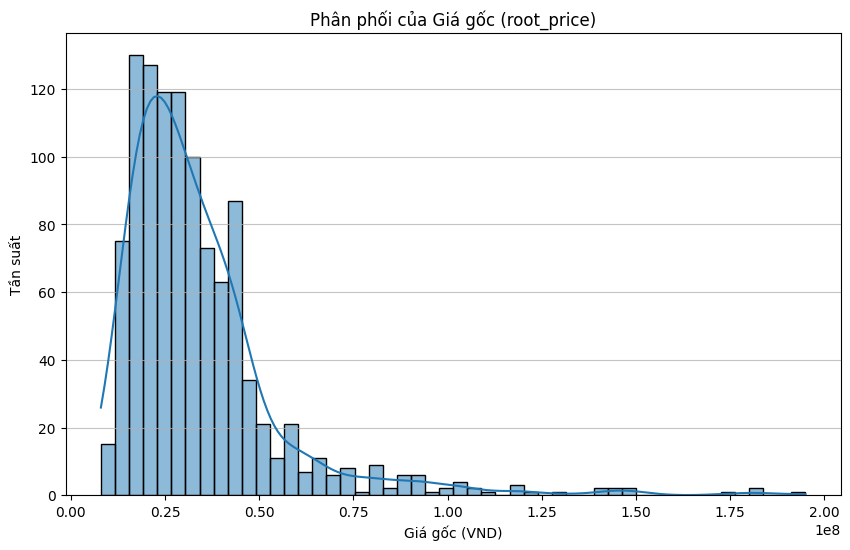

In [7]:
# Vẽ biểu đồ histogram kèm đường mật độ (KDE)
plt.figure(figsize=(10, 6))

sns.histplot(
    df["root_price"],
    kde=True 
)

plt.title("Phân phối của Giá gốc (root_price)")
plt.xlabel("Giá gốc (VND)")
plt.ylabel("Tần suất")
plt.grid(axis="y", alpha=0.75)
plt.show()

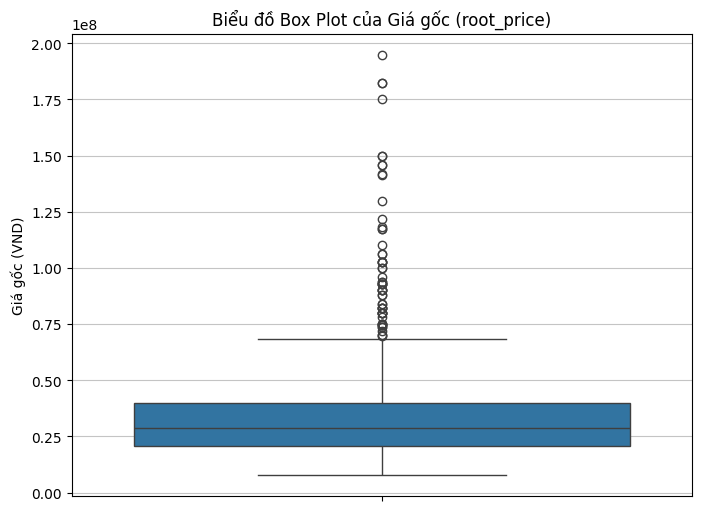

In [8]:
# Vẽ biểu đồ Box Plot cho cột 'root_price'
plt.figure(figsize=(8, 6))

sns.boxplot(y=df["root_price"])

plt.title("Biểu đồ Box Plot của Giá gốc (root_price)")
plt.ylabel("Giá gốc (VND)")
plt.grid(axis="y", alpha=0.75)
plt.show()


Vì các giá trị của root_price là giá trị thực, không lỗi nên có thể tiền xử lý bằng biến đổi logaric để giảm bớt lệch phải

**2. Phân tích đa biến**

In [9]:
# Danh sách cột theo từng loại
binary = [
    "is_installment", "cam_ung",'hoc_tap_van_phong', 'laptop_sang_tao_noi_dung', 'mong_nhe',
    'gaming', 'do_hoa_ky_thuat', 'cao_cap_sang_trong'
]

continuous = [
    "cpu_speed", "cpu_max_speed", "battery_capacity",
    "ram_speed", "display_height", "display_width", "display_size",
    "product_weight", "width_mm", "height_mm", "depth_mm"
]

discrete = [
    "ram_storage", "storage_gb", "storage_max_support", "cpu_cores", "cpu_threads",
    "refresh_rate", "ram_slots",'vga_vram'
]

categorical = [
    "laptop_color", "cpu_brand", "cpu_series", "cpu_model", "vga_type",
    "vga_brand", "os_version", "manufacturer", "ram_type",
    "material", "laptop_camera", "bluetooth_version"
]

metadata = [
    "image", "url_path", "product_id", "name"
]

column_groups = {
    "binary": binary,
    "continuous": continuous,
    "discrete": discrete,
    "categorical": categorical,
    "metadata": metadata
}

numeric = continuous + discrete
# In ra tổng kết số lượng cột mỗi nhóm
for group, cols in column_groups.items():
    print(f"{group.capitalize()} columns ({len(cols)}): {cols}")


Binary columns (8): ['is_installment', 'cam_ung', 'hoc_tap_van_phong', 'laptop_sang_tao_noi_dung', 'mong_nhe', 'gaming', 'do_hoa_ky_thuat', 'cao_cap_sang_trong']
Continuous columns (11): ['cpu_speed', 'cpu_max_speed', 'battery_capacity', 'ram_speed', 'display_height', 'display_width', 'display_size', 'product_weight', 'width_mm', 'height_mm', 'depth_mm']
Discrete columns (8): ['ram_storage', 'storage_gb', 'storage_max_support', 'cpu_cores', 'cpu_threads', 'refresh_rate', 'ram_slots', 'vga_vram']
Categorical columns (12): ['laptop_color', 'cpu_brand', 'cpu_series', 'cpu_model', 'vga_type', 'vga_brand', 'os_version', 'manufacturer', 'ram_type', 'material', 'laptop_camera', 'bluetooth_version']
Metadata columns (4): ['image', 'url_path', 'product_id', 'name']


2.1 Numeric columns

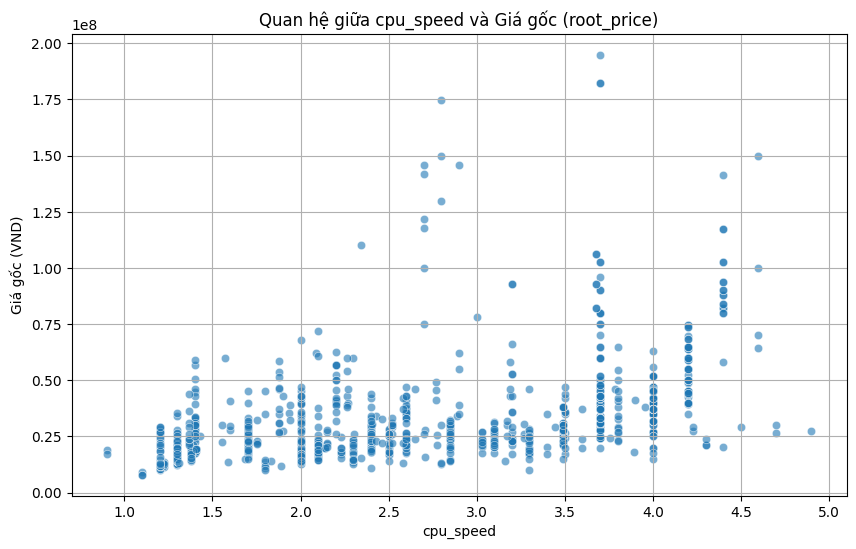

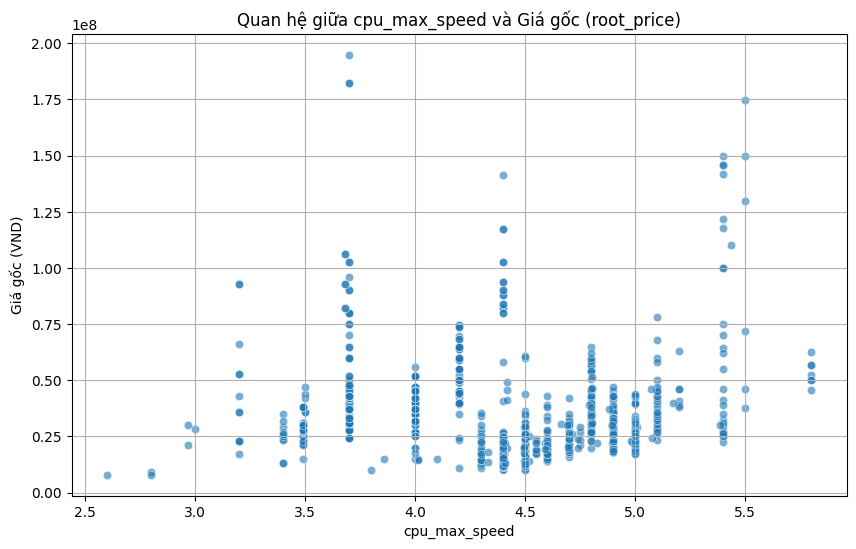

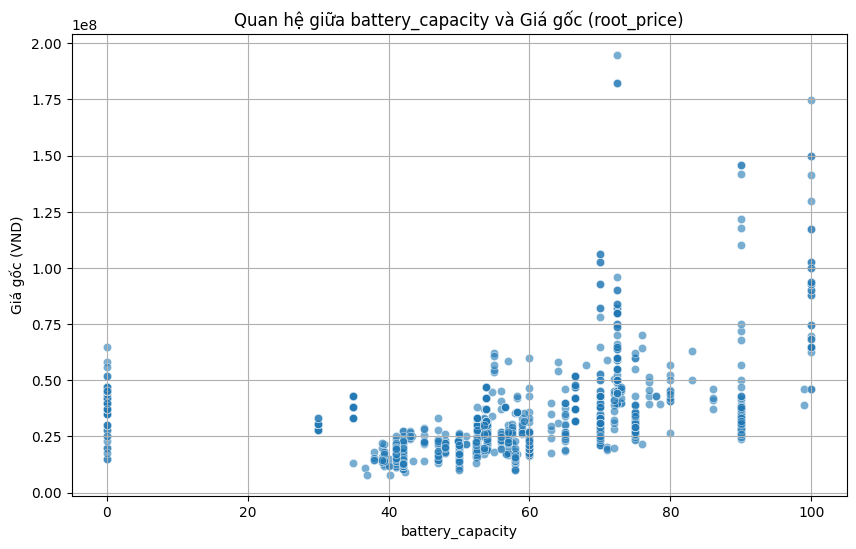

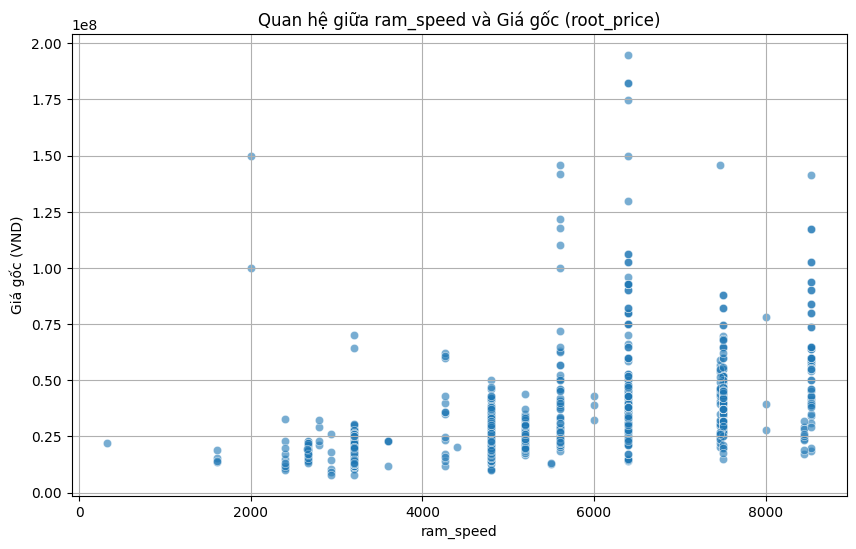

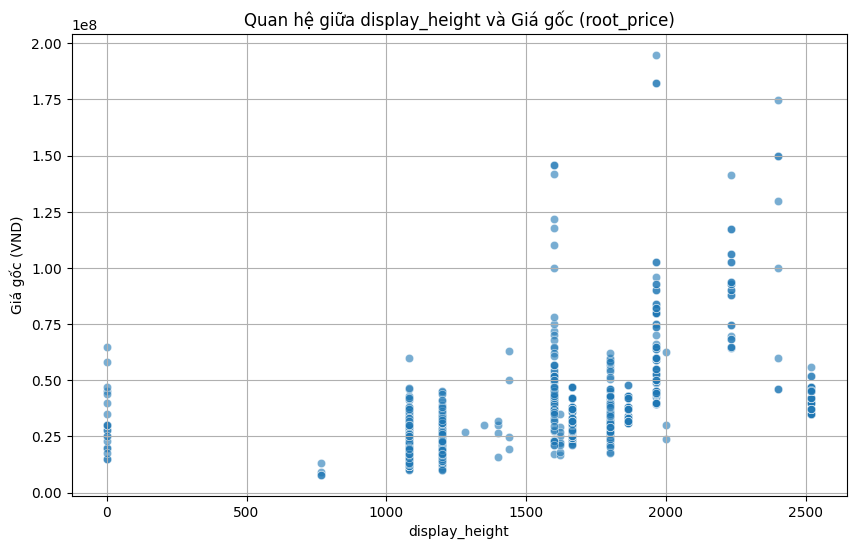

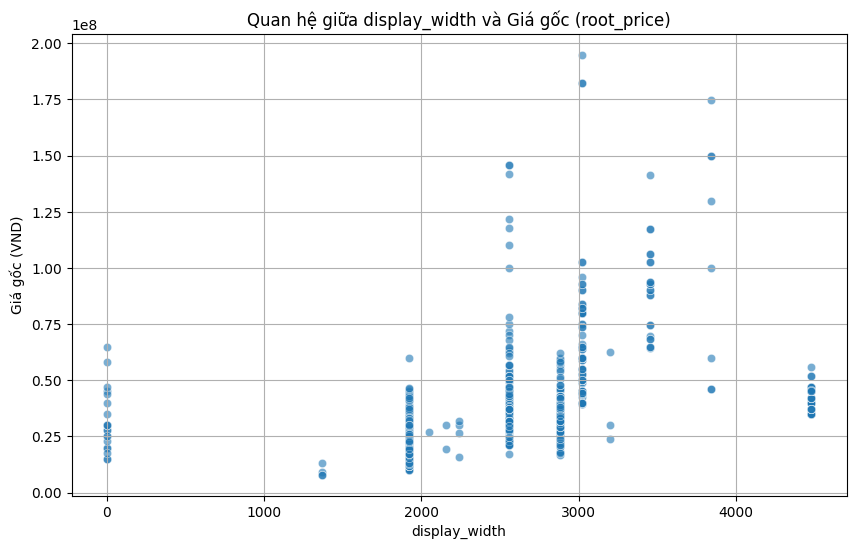

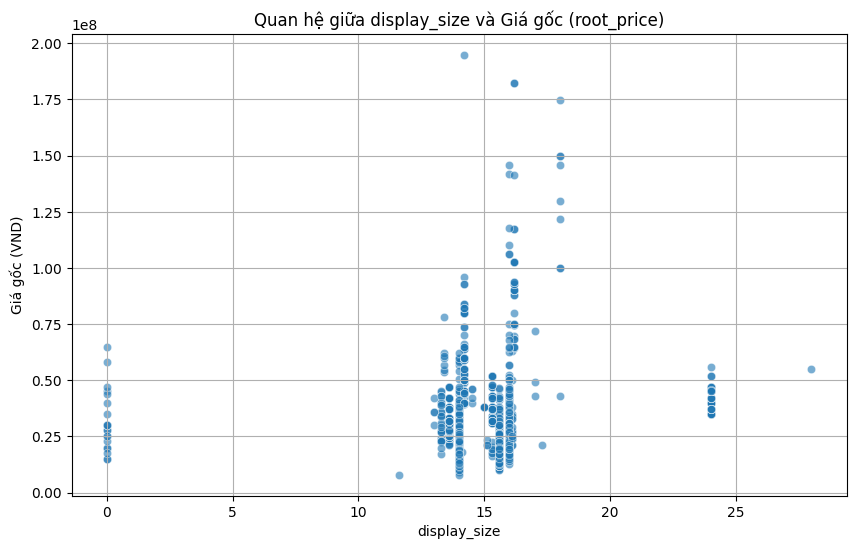

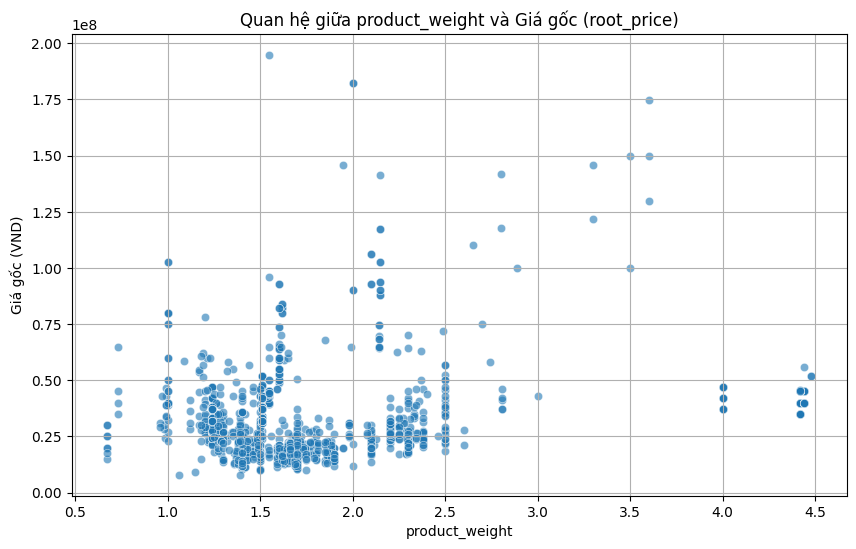

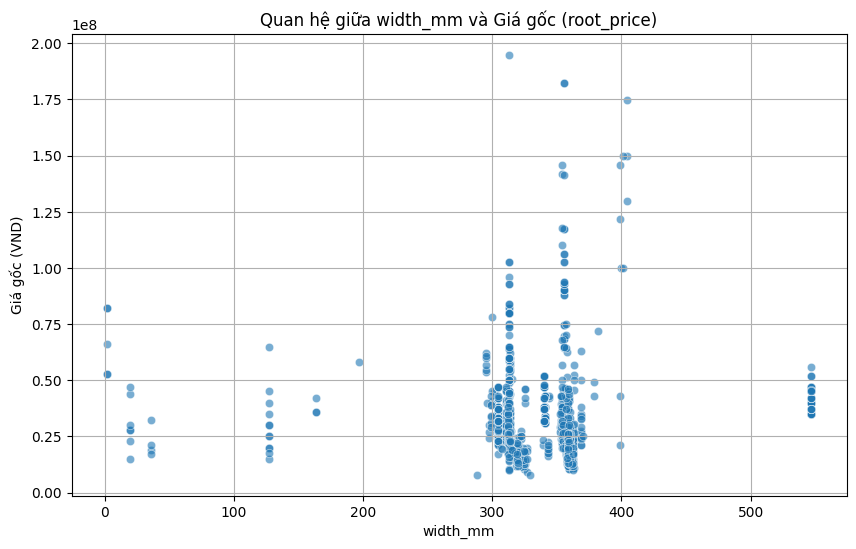

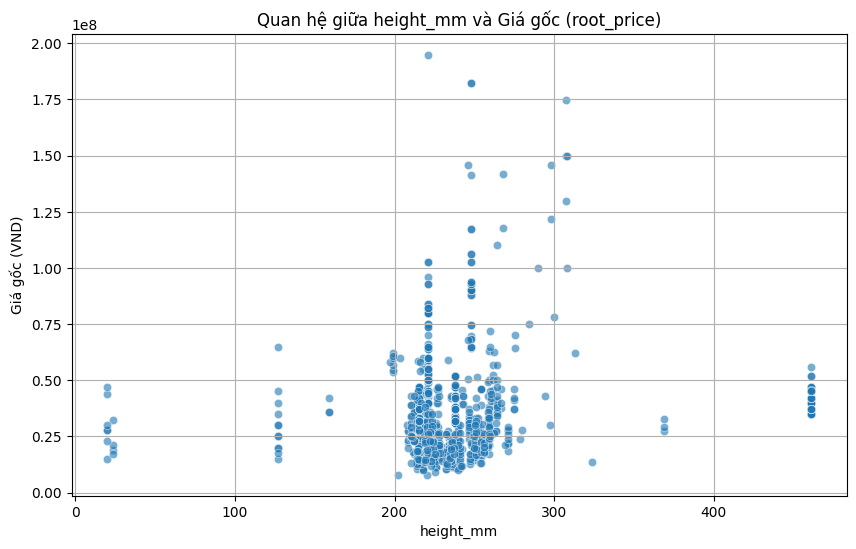

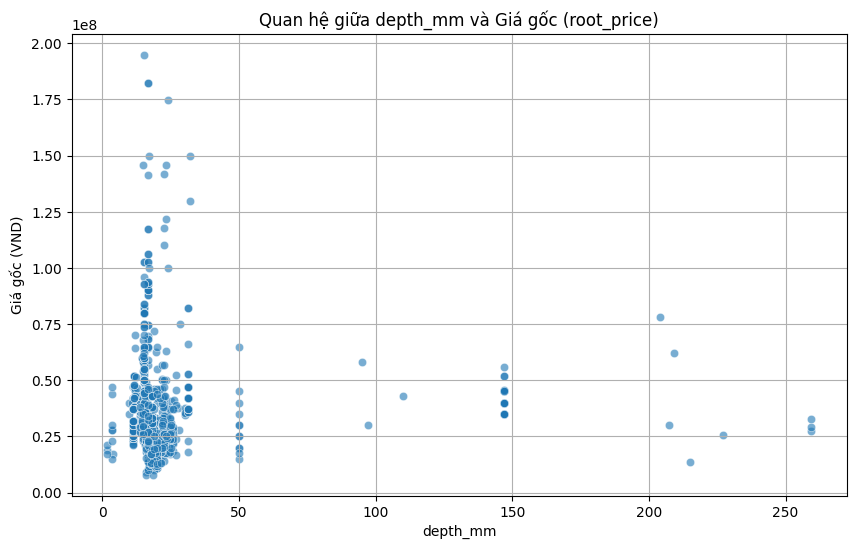

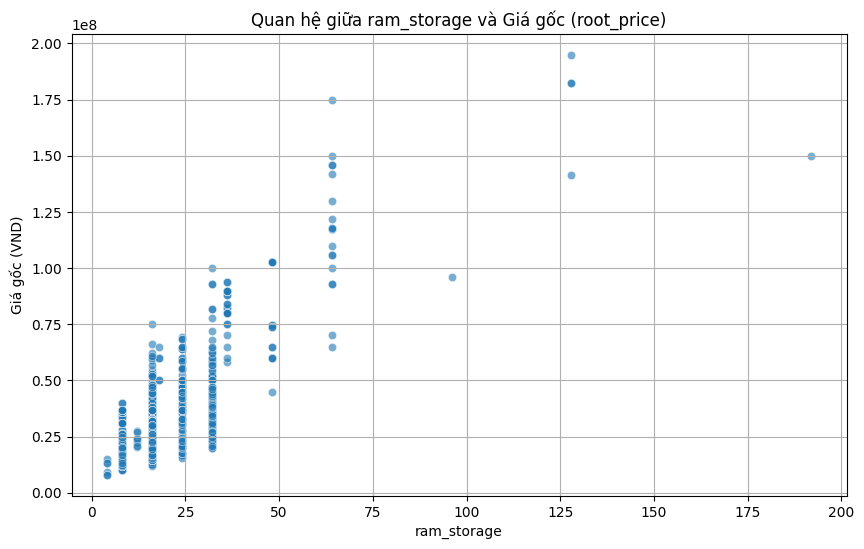

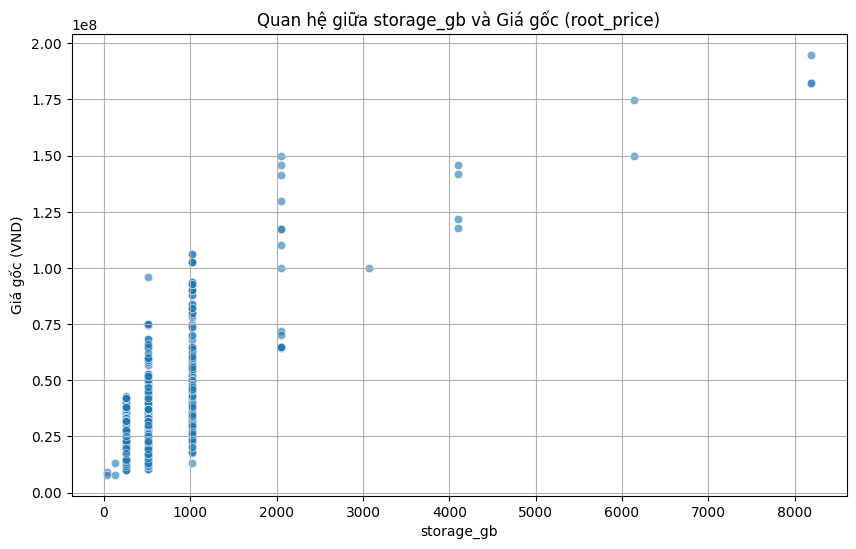

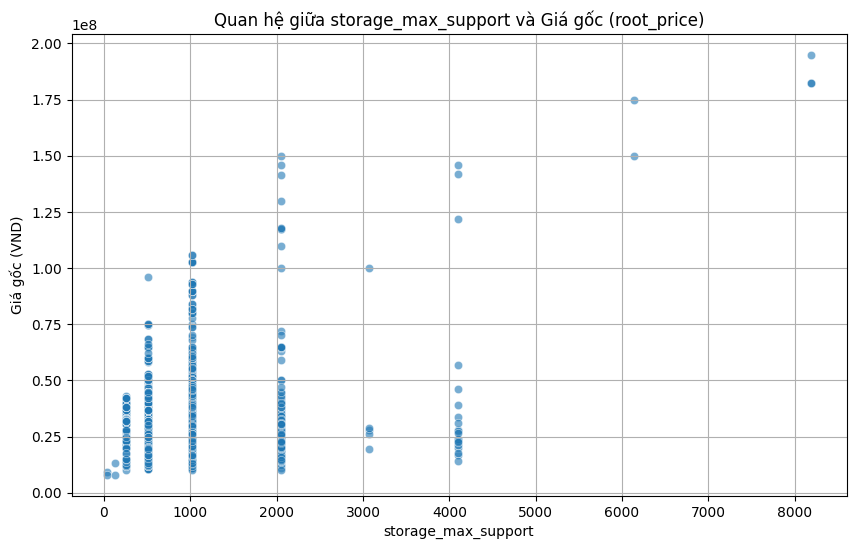

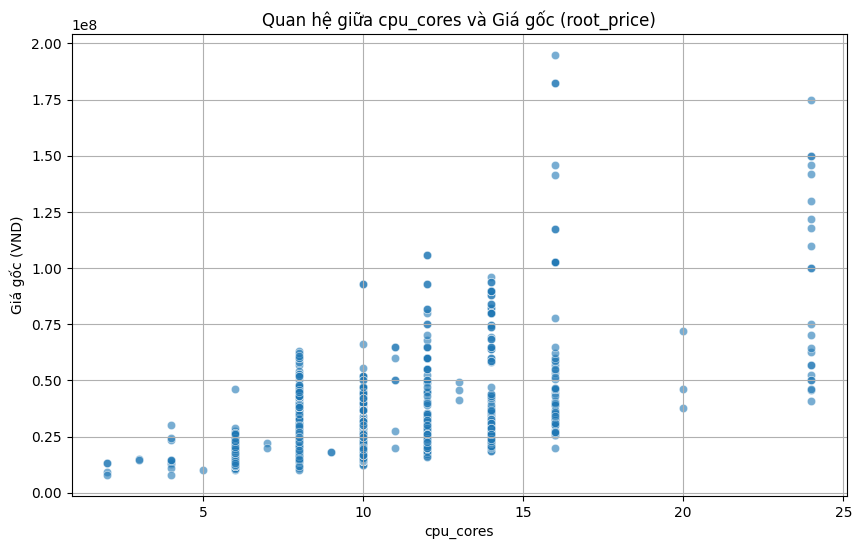

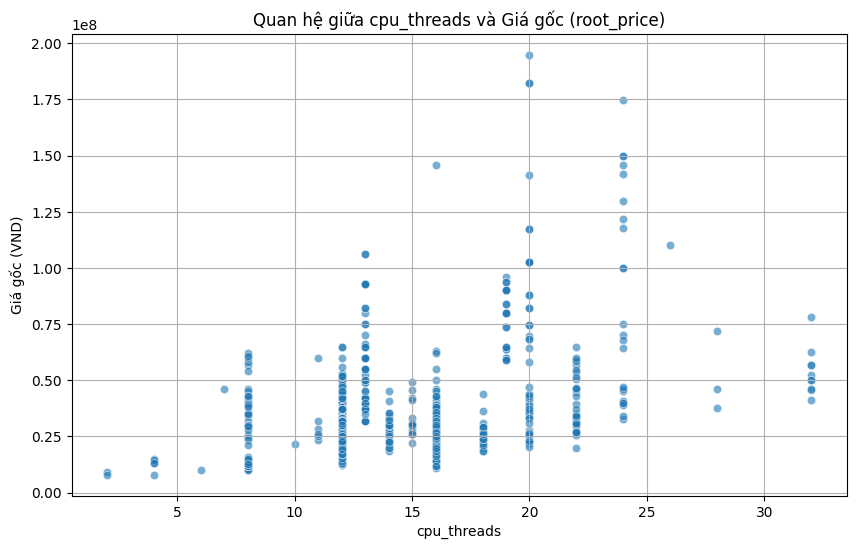

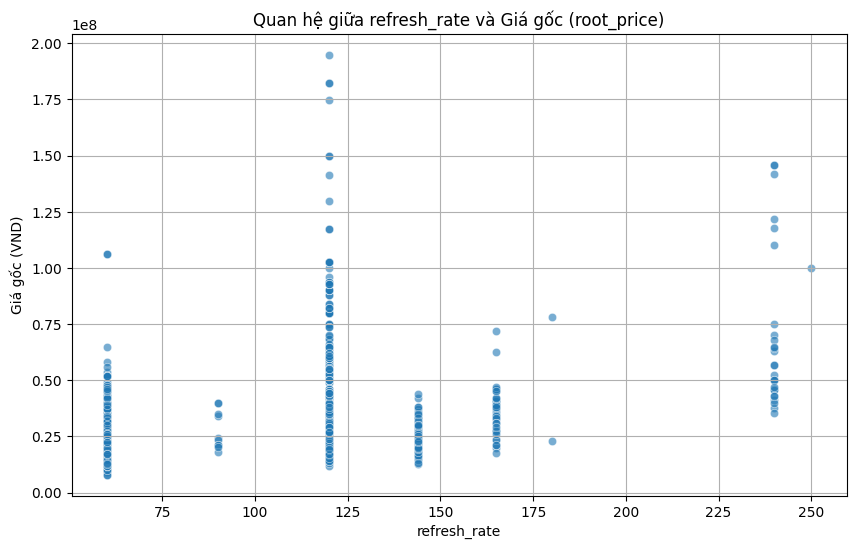

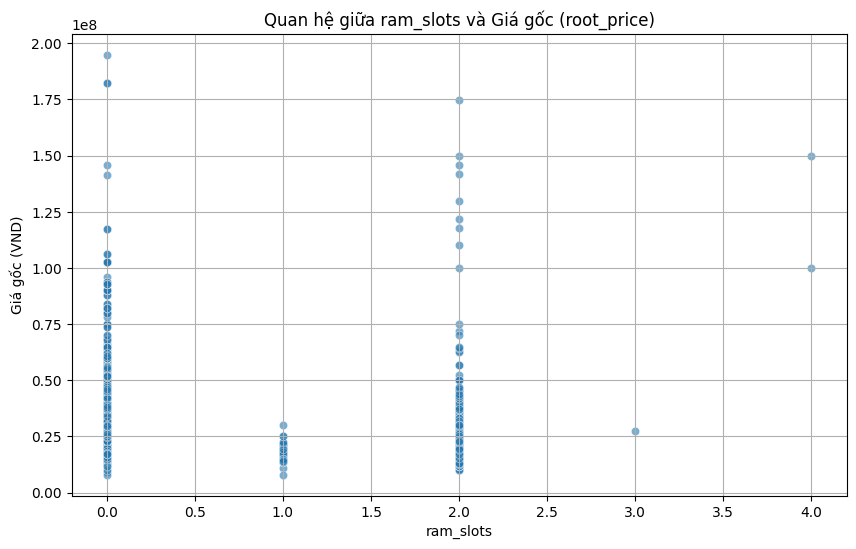

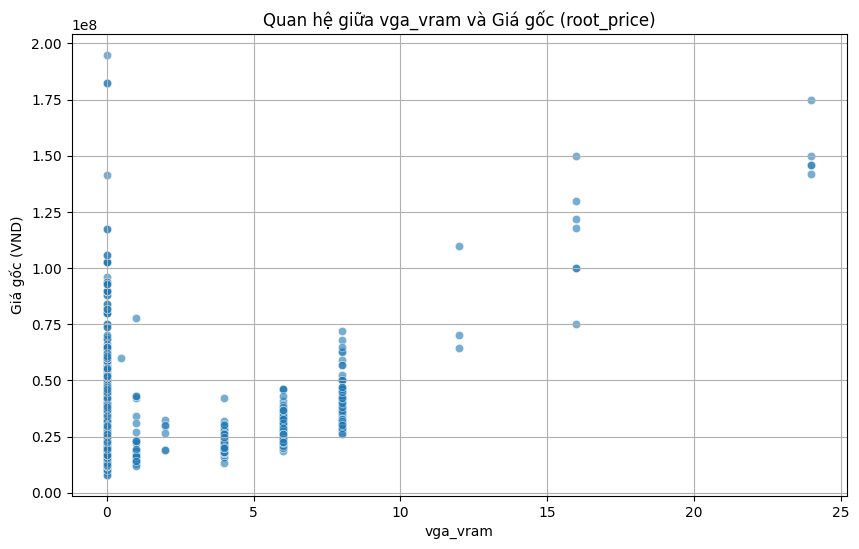

In [10]:
# Vẽ biểu đồ Scatter Plot giữa từng biến số và 'root_price'
for var in numeric:
    plt.figure(figsize=(10, 6))

    sns.scatterplot(
        x=df[var],
        y=df["root_price"],
        alpha=0.6
    )

    plt.title(f"Quan hệ giữa {var} và Giá gốc (root_price)")
    plt.xlabel(var)
    plt.ylabel("Giá gốc (VND)")
    plt.grid(True)
    plt.show()


Hầu hết các biến đều có tưởng quan dương với root_price trừ các cột các yếu tố liên quan đến kích thước 'display_height', 'display_width', 'display_size', 'product_weight', 'width_mm', 'height_mm', 'depth_mm'

2.2 Categorical columns


Phân tích biến: laptop_color
Số lượng giá trị unique: 11


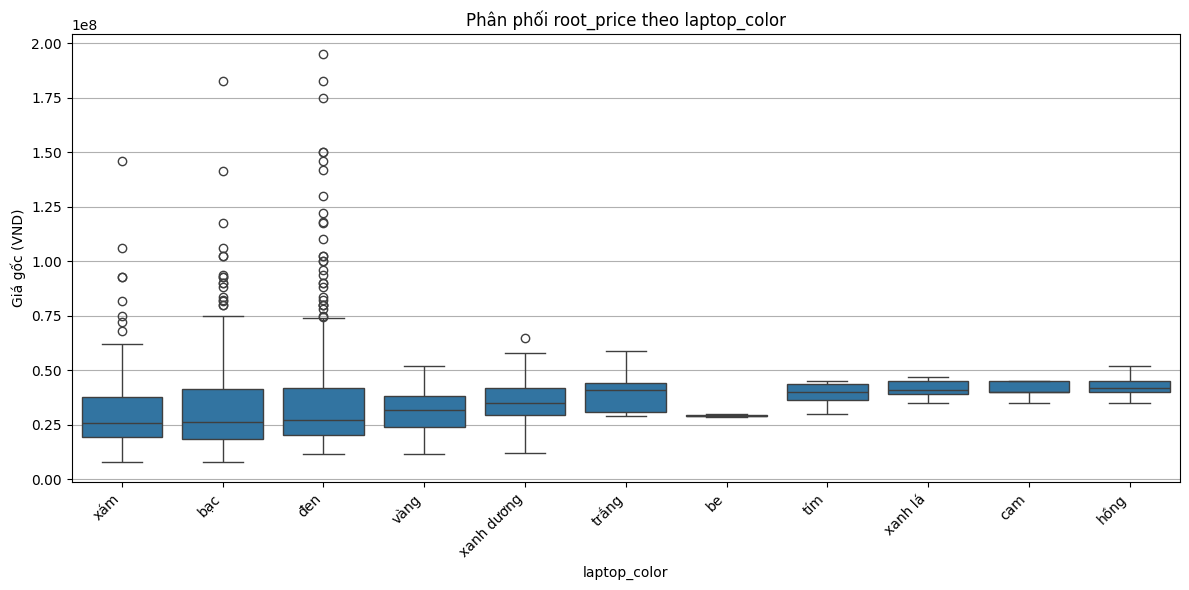

------------------------------

Phân tích biến: cpu_brand
Số lượng giá trị unique: 4


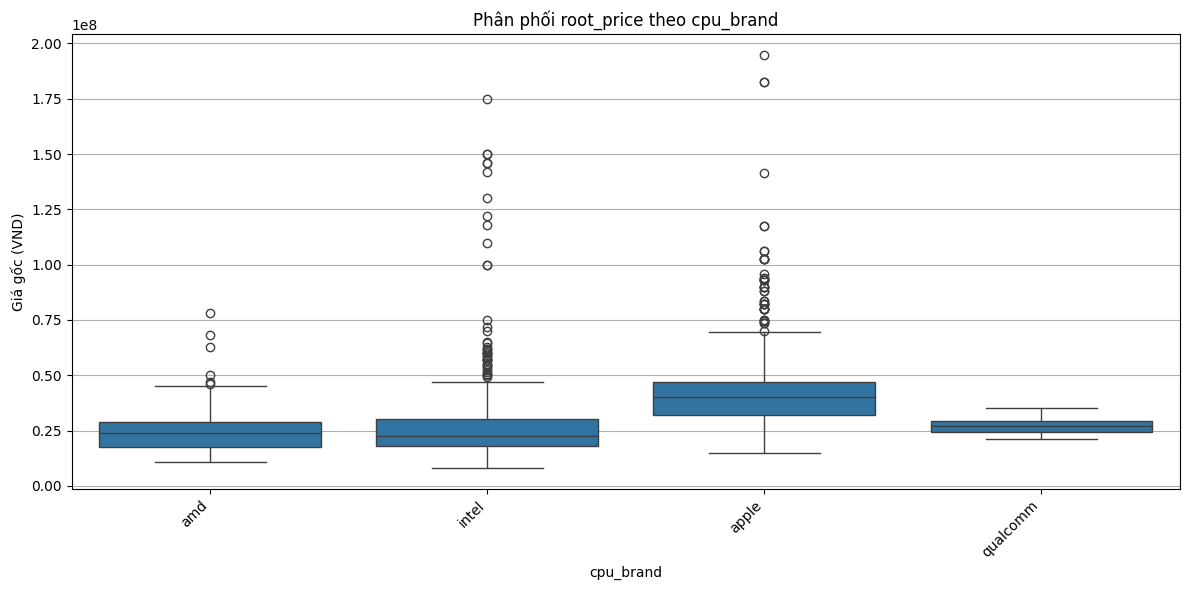

------------------------------

Phân tích biến: cpu_series
Số lượng giá trị unique: 36
Biến 'cpu_series' có số lượng giá trị unique lớn (36).
Hiển thị Bar Plot của giá trung bình cho top 15 danh mục phổ biến nhất.


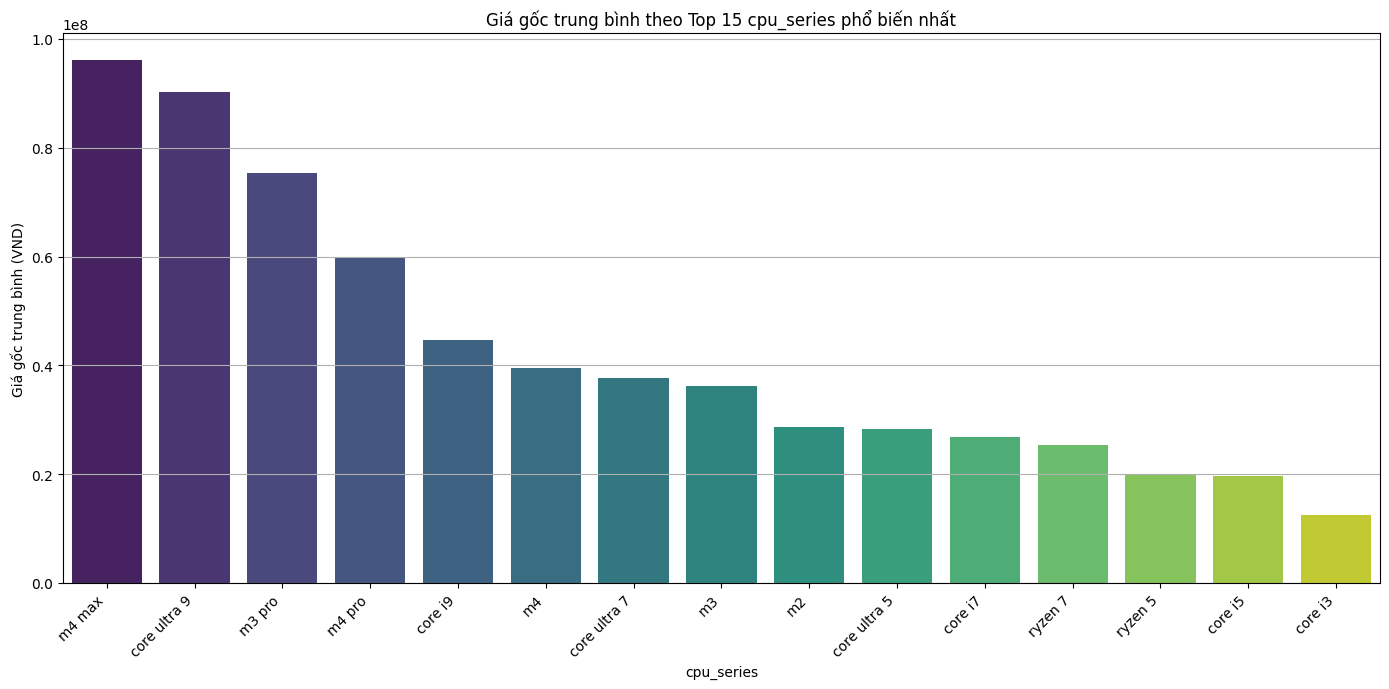

------------------------------

Phân tích biến: cpu_model
Số lượng giá trị unique: 112
Biến 'cpu_model' có số lượng giá trị unique lớn (112).
Hiển thị Bar Plot của giá trung bình cho top 15 danh mục phổ biến nhất.


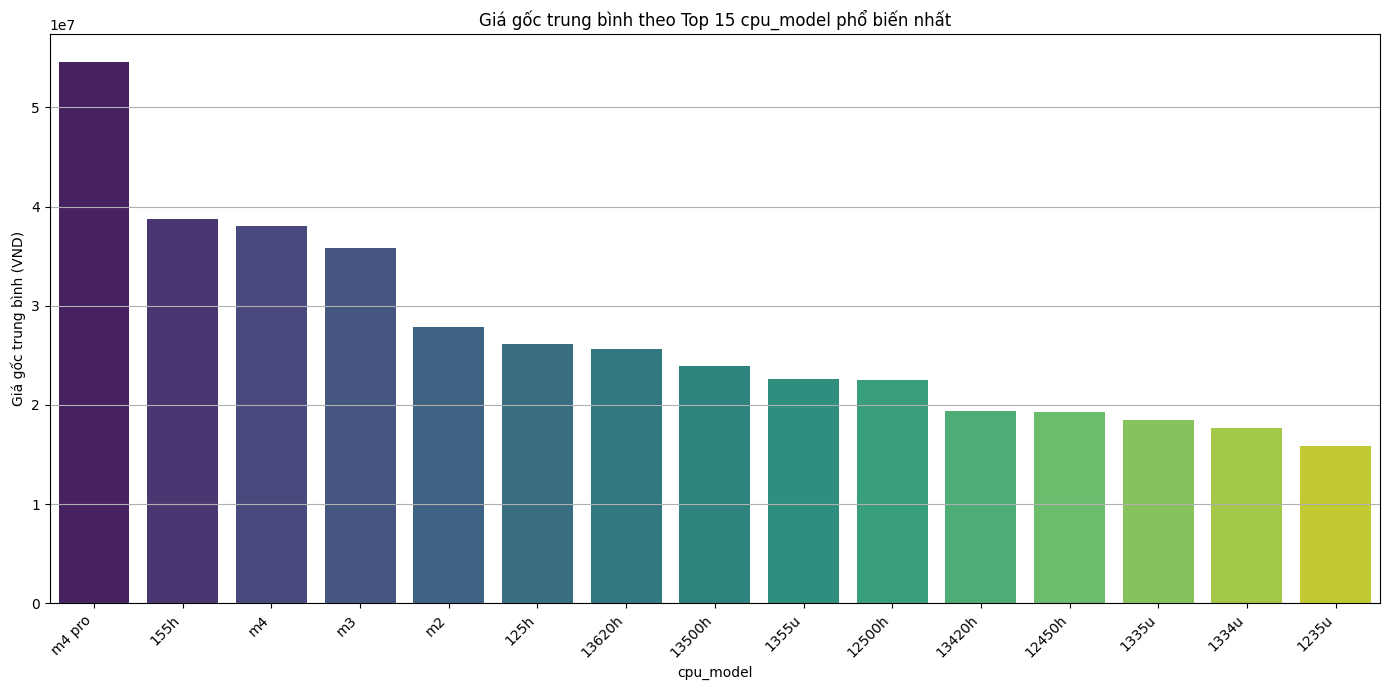

------------------------------

Phân tích biến: vga_type
Số lượng giá trị unique: 2


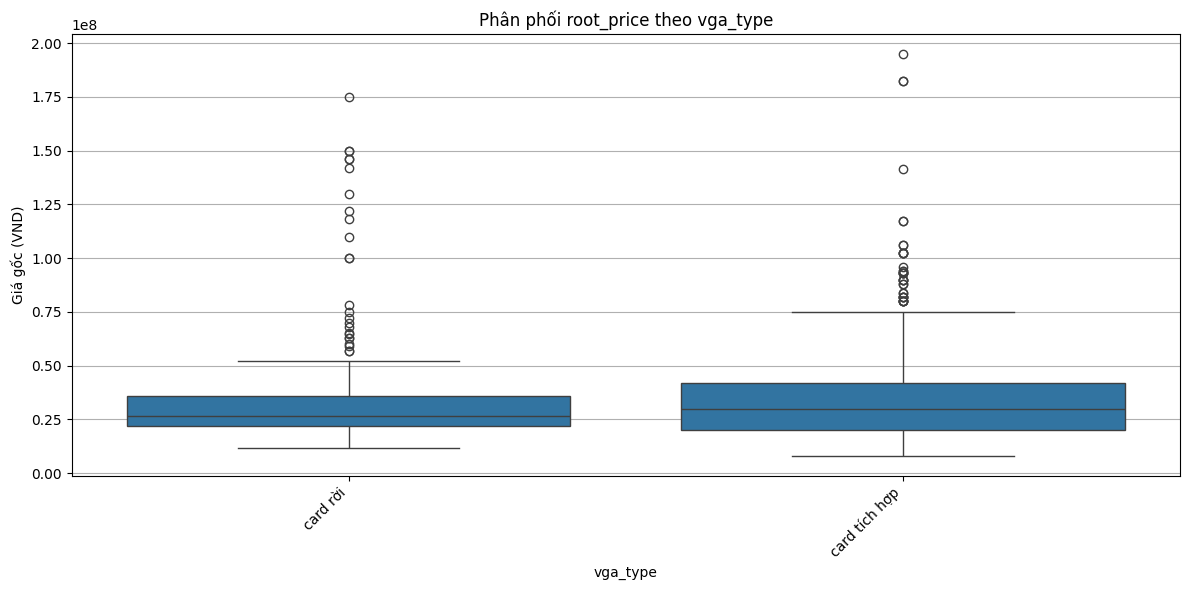

------------------------------

Phân tích biến: vga_brand
Số lượng giá trị unique: 5


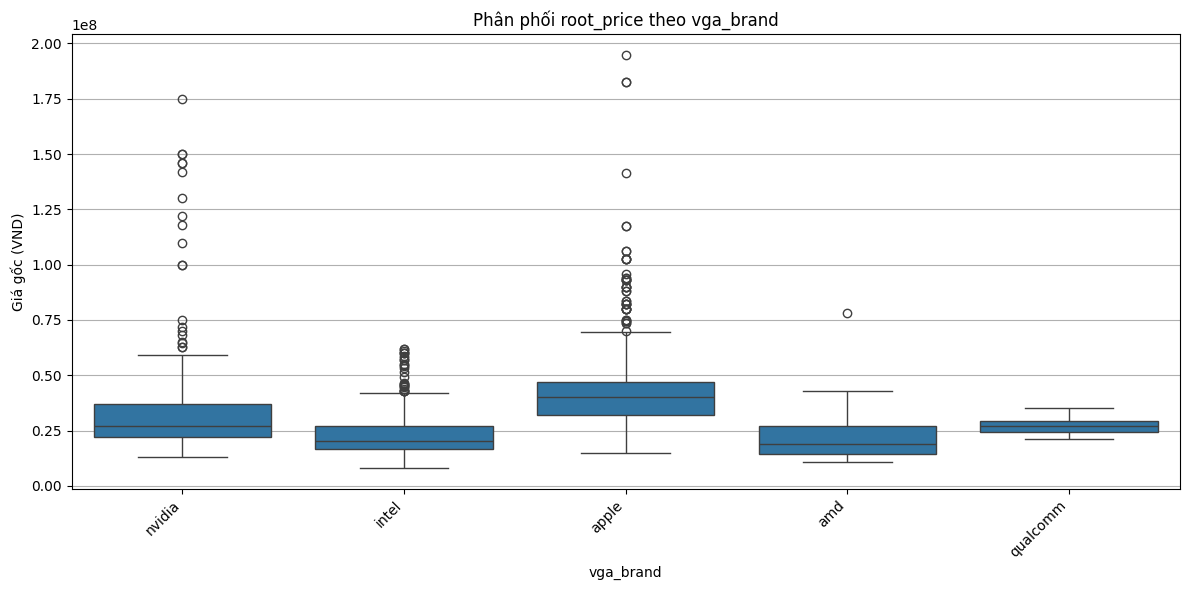

------------------------------

Phân tích biến: os_version
Số lượng giá trị unique: 5


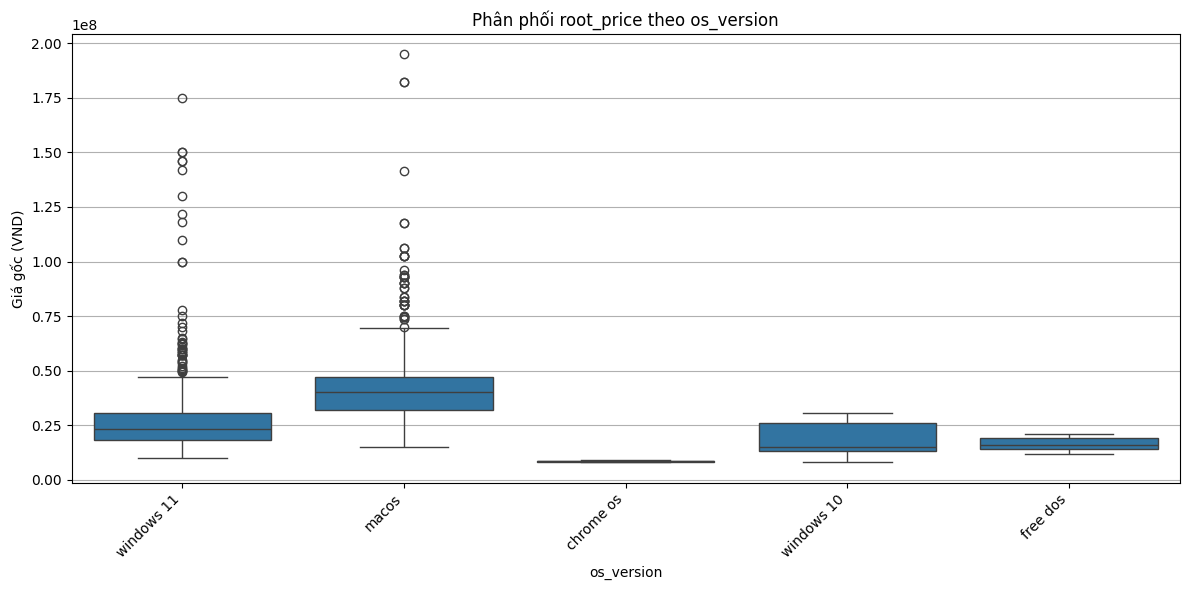

------------------------------

Phân tích biến: manufacturer
Số lượng giá trị unique: 13


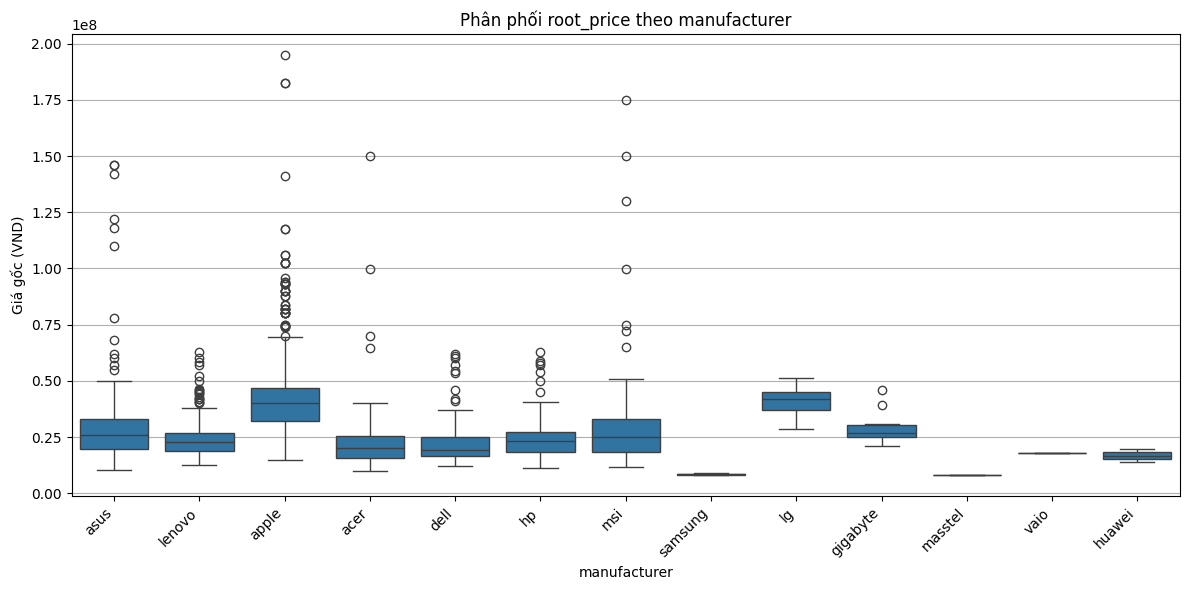

------------------------------

Phân tích biến: ram_type
Số lượng giá trị unique: 7


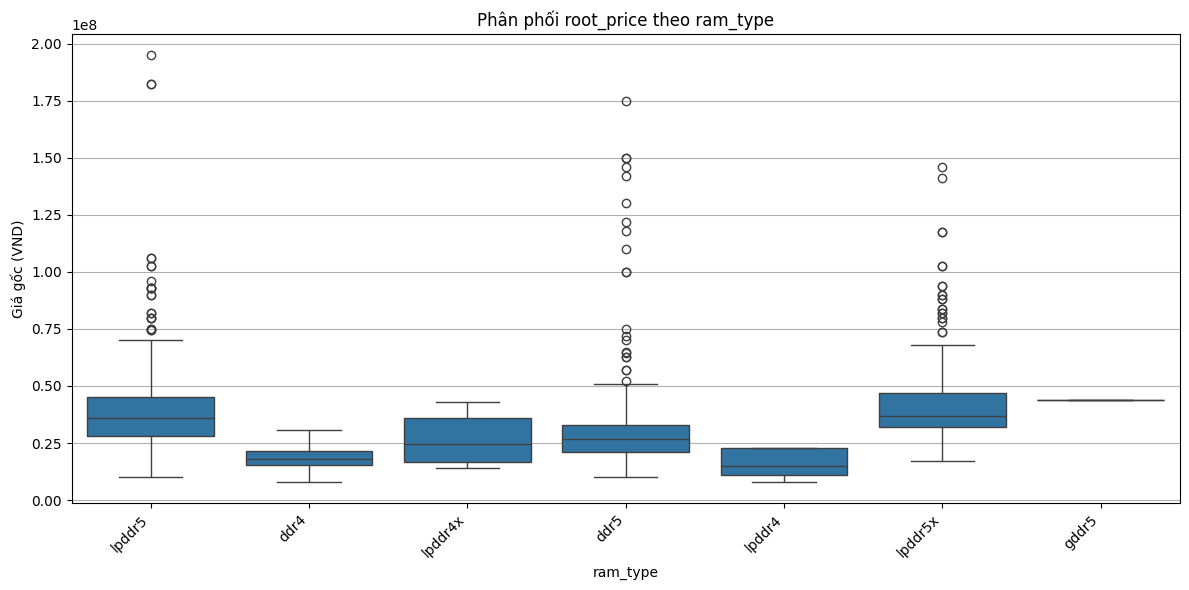

------------------------------

Phân tích biến: material
Số lượng giá trị unique: 3


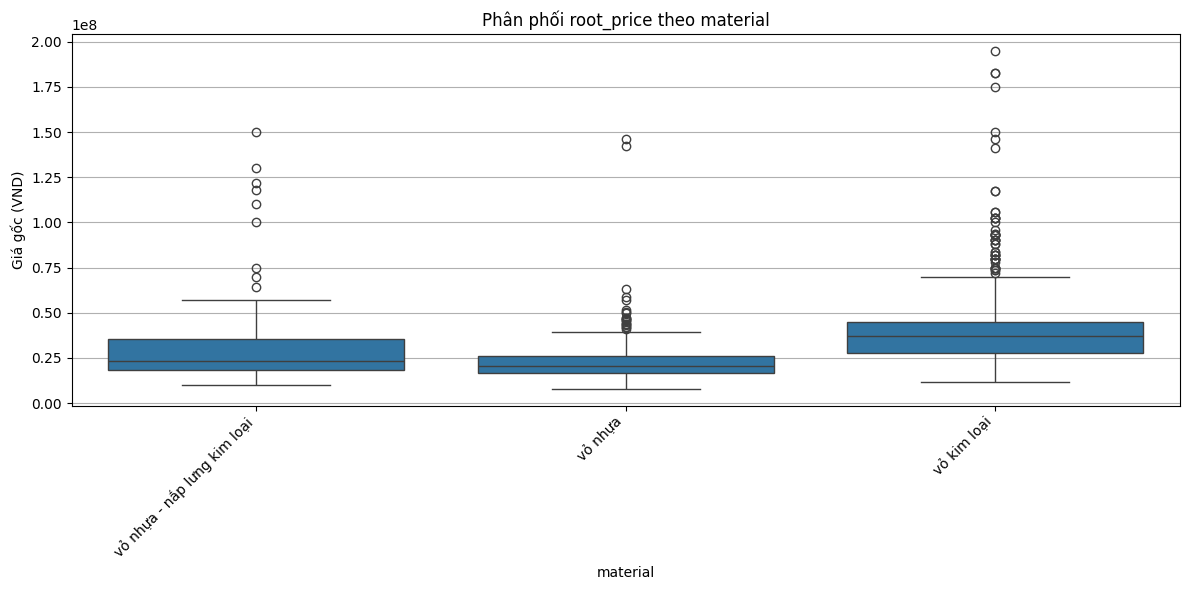

------------------------------

Phân tích biến: laptop_camera
Số lượng giá trị unique: 2


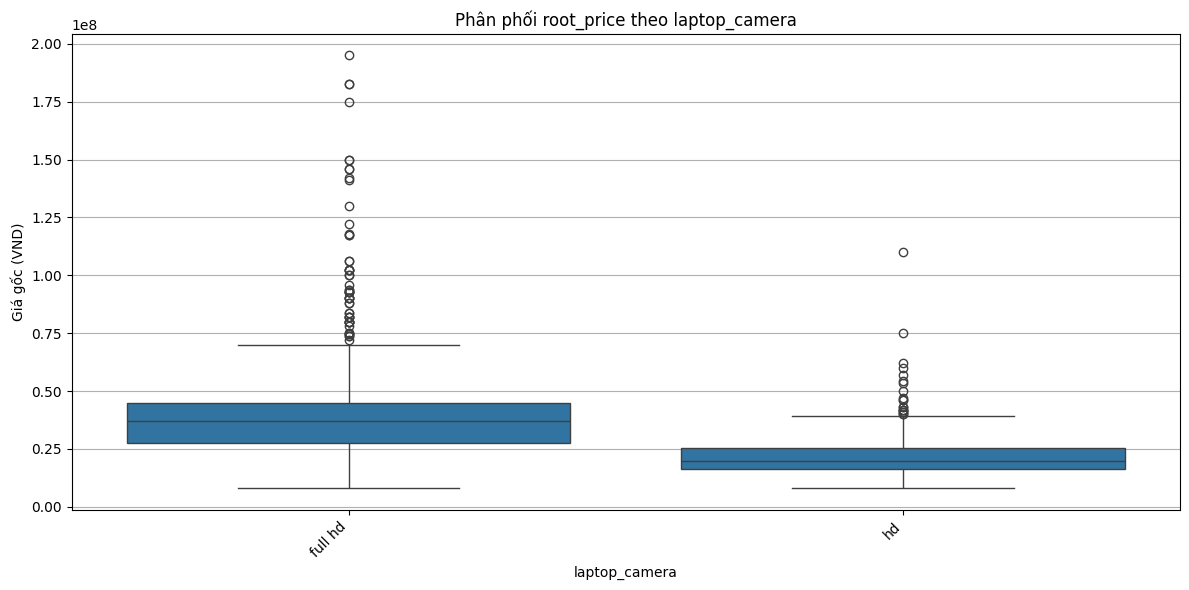

------------------------------

Phân tích biến: bluetooth_version
Số lượng giá trị unique: 7


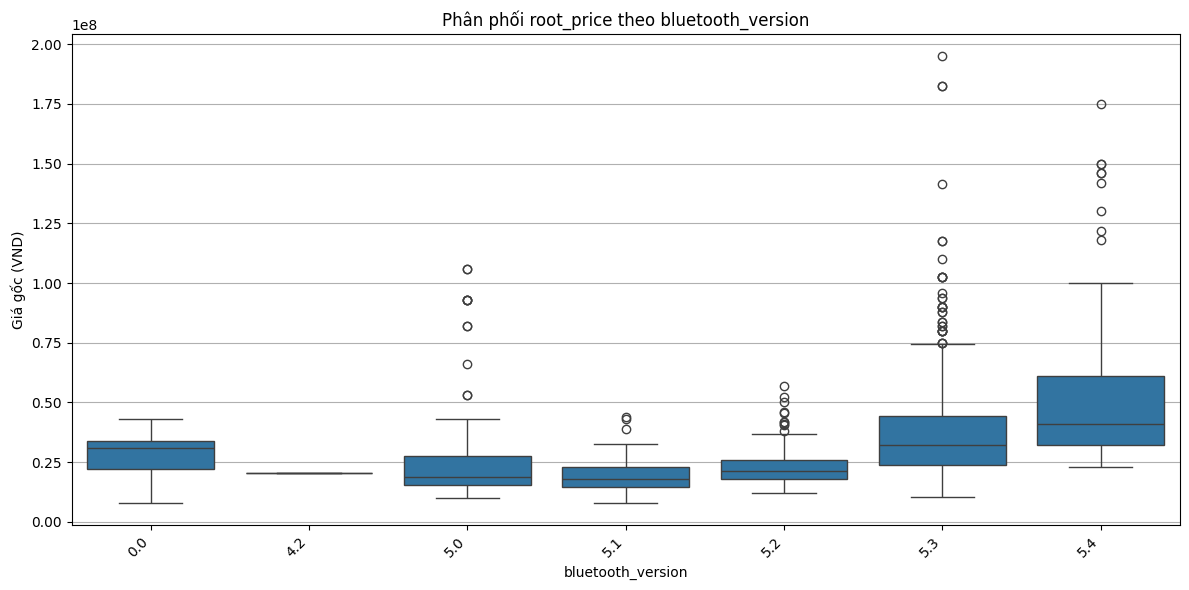

------------------------------


In [11]:
# Phân tích các biến phân loại (categorical)
for var in categorical:
    print(f"\nPhân tích biến: {var}")

    # Kiểm tra số lượng giá trị unique
    num_unique = df[var].nunique()
    print(f"Số lượng giá trị unique: {num_unique}")

    # Ngưỡng số lượng danh mục để quyết định vẽ Box Plot hay Bar Plot
    cardinality_threshold_boxplot = 30

    if num_unique > cardinality_threshold_boxplot:
        print(f"Biến '{var}' có số lượng giá trị unique lớn ({num_unique}).")
        print("Hiển thị Bar Plot của giá trung bình cho top 15 danh mục phổ biến nhất.")

        # Lấy top N danh mục phổ biến nhất và tính giá trung bình
        top_n = 15
        top_categories = df[var].value_counts().nlargest(top_n).index
        df_top = df[df[var].isin(top_categories)].copy()

        if not df_top.empty:
            mean_price_by_cat = (
                df_top.groupby(var)["root_price"]
                .mean()
                .sort_values(ascending=False)
            )

            plt.figure(figsize=(14, 7))
            sns.barplot(
                x=mean_price_by_cat.index,
                y=mean_price_by_cat.values,
                palette="viridis"
            )
            plt.title(f"Giá gốc trung bình theo Top {top_n} {var} phổ biến nhất")
            plt.xlabel(var)
            plt.ylabel("Giá gốc trung bình (VND)")
            plt.xticks(rotation=45, ha="right")
            plt.grid(axis="y")
            plt.tight_layout()
            plt.show()
        else:
            print(f"Không có dữ liệu cho top {top_n} danh mục của biến '{var}'.")

    else:
        # Vẽ Box Plot nếu số lượng danh mục không quá nhiều
        plt.figure(figsize=(12, 6))

        sns.boxplot(x=df[var], y=df["root_price"])
        plt.title(f"Phân phối root_price theo {var}")
        plt.xlabel(var)
        plt.ylabel("Giá gốc (VND)")
        plt.xticks(rotation=45, ha="right")
        plt.grid(axis="y")
        plt.tight_layout()
        plt.show()

    print("-" * 30)


- **Manufacturer**: LG có giá trung vị cao nhất, Apple có phạm vi giá rộng nhất với nhiều sản phẩm ngoại lai gần 200 triệu VND.
- **vga_type**: Card rời có giá trung vị cao hơn card tích hợp, phù hợp với phân khúc cao cấp (gaming, đồ họa).
- **os_version**: macOS dẫn đầu về giá trung bình, tiếp theo là Windows 11, Windows 10, Free DOS, và thấp nhất là Chrome OS; macOS có phạm vi giá rộng nhất.
- **ram_type**: LPDDR5X và LPDDR5 gắn với giá cao (phân khúc cao cấp), DDR4 và LPDDR4 thuộc tầm trung/thấp.
- **material**: Vỏ kim loại đại diện phân khúc cao cấp, nhựa cho cơ bản, nhựa + kim loại là lựa chọn cân bằng.
- **vga_brand**: Apple và NVIDIA thuộc cao cấp, Intel và AMD phổ thông/tầm trung, Qualcomm đặc thù và ổn định.
- **laptop_camera**: Webcam Full HD tăng giá rõ rệt.
- **bluetooth_version**: Giá trung bình tăng từ 4.2 (0.25-0.5 triệu) đến 5.4 (0.5-1.0 triệu), 5.4 có phân tán và ngoại lai lớn.
- **laptop_color**: Màu đen và xám có giá cao hơn (lên đến 1.0 triệu) với phân tán lớn, be và tím thấp và ổn định (0.25 triệu).
- **cpu_series**: M4 Max cao nhất (gần 1.0 triệu), giảm dần đến Core i3 (0.1 triệu); cao cấp ổn định, thấp phân tán ít.
- **cpu_model**: M4 Pro cao nhất (gần 5 triệu), giảm dần đến i3-135U (1 triệu); cao cấp ổn định, i3 phân tán thấp.

In [12]:
df.loc[df['manufacturer'] == 'apple', 'vga_type'] = 'card tích hợp'


--- Phân tích Quan hệ giữa root_price và VGA Brand (chỉ Card rời) ---
Số lượng VGA Brands cho laptop có card rời: 3


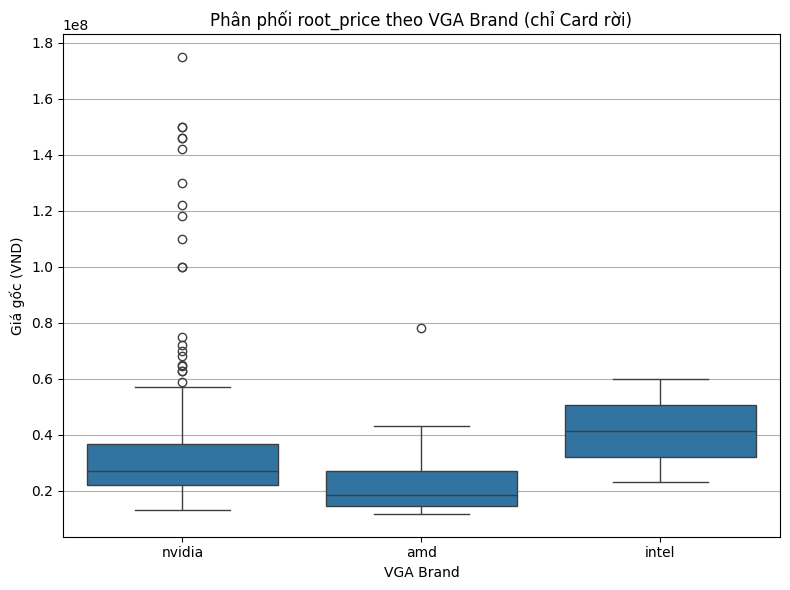

In [13]:
print("\n--- Phân tích Quan hệ giữa root_price và VGA Brand (chỉ Card rời) ---")

# Lọc dữ liệu chỉ gồm laptop có card rời
df_card_roi = df[df["vga_type"] == "card rời"].copy()

if not df_card_roi.empty and df_card_roi["vga_brand"].nunique() > 1:
    num_brands = df_card_roi["vga_brand"].nunique()
    print(f"Số lượng VGA Brands cho laptop có card rời: {num_brands}")

    plt.figure(figsize=(8, 6))

    sns.boxplot(
        x=df_card_roi["vga_brand"],
        y=df_card_roi["root_price"]
    )

    plt.title("Phân phối root_price theo VGA Brand (chỉ Card rời)")
    plt.xlabel("VGA Brand")
    plt.ylabel("Giá gốc (VND)")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

elif df_card_roi.empty:
    print("Không có dữ liệu laptop có card rời trong dataset.")
else:
    only_brand = df_card_roi["vga_brand"].iloc[0]
    print(
        f"Chỉ có một VGA Brand duy nhất ({only_brand}) cho laptop có card rời, không thể so sánh giữa các hãng."
    )


**Phân tích root_price theo vga_type(card rời)**
- Intel (card rời Intel) có giá trung bình cao nhất, vì median (đường ngang trong hộp) cao hơn rõ rệt so với NVIDIA và AMD. Hộp cũng nằm cao hơn toàn bộ 2 hãng còn lại.
- Thứ tự giá trung bình giảm dần: Intel > Nvidia > AMD
- Mặc dù NVIDIA có nhiều sản phẩm cao cấp (nhiều outlier lên đến 170 triệu VND), nhưng giá trung bình/median lại thấp hơn Intel.

In [14]:
def run_anova_with_tukey(
    df,
    categorical,
    target_col="root_price",
    min_group_size=3,
    max_unique=30,
):
    """
    Thực hiện ANOVA và Tukey HSD cho một biến phân loại so với biến mục tiêu định lượng.

    Parameters:
    - df: DataFrame gốc
    - categorical: Tên cột phân loại (string)
    - target_col: Tên biến mục tiêu định lượng
    - min_group_size: Số lượng mẫu tối thiểu cho mỗi nhóm
    - max_unique: Số lượng nhóm tối đa để thực hiện ANOVA
    """
    try:
        num_unique = df[categorical].nunique()
        if num_unique >= max_unique:
            print(
                f"[{categorical}] Skipping: quá nhiều nhóm ({num_unique}). "
                "Cần gom nhóm hoặc loại bỏ."
            )
            return

        # Lọc nhóm có đủ số lượng mẫu
        valid_groups = df[categorical].value_counts().loc[lambda x: x >= min_group_size].index
        df_anova = df[df[categorical].isin(valid_groups)]

        if df_anova[categorical].nunique() <= 1:
            print(
                f"[{categorical}] Skipping: không đủ nhóm hợp lệ sau khi lọc "
                f"(>= {min_group_size} mẫu mỗi nhóm)."
            )
            return

        # Làm sạch tên cột để dùng trong công thức ANOVA
        clean_col = "".join(c if c.isalnum() else "_" for c in categorical)
        df_anova = df_anova.rename(columns={categorical: clean_col, target_col: "target_price_clean"})

        # ANOVA
        model = ols(f"target_price_clean ~ C({clean_col})", data=df_anova).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        pval = anova_table["PR(>F)"][0]

        print(f"\n>>> ANOVA cho '{target_col}' theo nhóm '{categorical}' ({num_unique} nhóm ban đầu):")
        print(anova_table)

        if pval < 0.05:
            print(f"  -> Có sự khác biệt có ý nghĩa giữa các nhóm (p = {pval:.3f})")

            # Tukey HSD
            tukey = pairwise_tukeyhsd(
                df_anova["target_price_clean"],
                df_anova[clean_col],
                alpha=0.05,
            )
            print("\n  >> Kết quả Tukey HSD:")
            print(tukey)

            # In các cặp có khác biệt có ý nghĩa
            sig_pairs = tukey.summary().data[1:]  # Bỏ header
            significant = [row for row in sig_pairs if row[-1] is True]

            if significant:
                print("\n  >> Các cặp nhóm có khác biệt có ý nghĩa:")
                for row in significant:
                    print(f"    - {row[0]} vs {row[1]}")
            else:
                print("  -> Không có cặp nhóm nào có khác biệt có ý nghĩa.")
        else:
            print(f"  -> Không có sự khác biệt có ý nghĩa giữa các nhóm (p = {pval:.3f})")

    except Exception as e:
        print(f"❌ Lỗi khi xử lý {categorical}: {e}")


In [15]:
def run_anova_for_all_categoricals(df, categorical_list, target_col='root_price'):
    """
    Lặp qua toàn bộ các biến phân loại để chạy ANOVA + Tukey HSD.
    """
    for cat in categorical_list:
        run_anova_with_tukey(df, categorical=cat, target_col=target_col)

In [16]:
run_anova_for_all_categoricals(df, categorical_list=categorical, target_col='root_price')


>>> ANOVA cho 'root_price' theo nhóm 'laptop_color' (11 nhóm ban đầu):
                       sum_sq      df       F    PR(>F)
C(laptop_color)  9.998517e+15     9.0  2.3892  0.011151
Residual         4.947458e+17  1064.0     NaN       NaN
  -> Có sự khác biệt có ý nghĩa giữa các nhóm (p = 0.011)

  >> Kết quả Tukey HSD:
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
  group1     group2      meandiff    p-adj      lower          upper     reject
-------------------------------------------------------------------------------
       bạc        cam   7630147.6015 0.9988 -23224861.6313 38485156.8342  False
       bạc       hồng    9185703.157 0.9626 -13978315.3259   32349721.64  False
       bạc      trắng   6487290.4586 0.9988 -19684264.0892 32658845.0064  False
       bạc        tím   5796814.2681 0.9997 -22420807.0672 34014435.6035  False
       bạc       vàng  -2147185.7319  0.999 -11067159.1372  6772787.6735  False
       bạc xanh dương   2167605.2286 

- laptop_color: Có sự khác biệt nhẹ về giá giữa các màu sắc, nhưng không đáng kể về mặt cặp nhóm.
- cpu_brand: Apple có mức giá cao vượt trội so với các hãng còn lại.
- vga_type: Việc phân chia theo vga_type không mang lại khác biệt về giá (có thể do các yếu tố khác chi phối mạnh hơn như CPU, RAM...).
- vga_brand: Thương hiệu VGA ảnh hưởng đến giá, đặc biệt là Apple và Nvidia.
- os_version: Giá máy MacOS cao vượt trội, còn giữa các phiên bản Windows thì không có khác biệt rõ.
- mannufacturer: Hãng sản xuất là yếu tố ảnh hưởng mạnh đến giá laptop.
- cpu_model và cpu_series: Bỏ qua do có quá nhiều nhóm (36 và 112 tương ứng). Cần gom nhóm hoặc loại bỏ để tránh overfitting.

2.3 Binary columns


Phân tích biến: is_installment
Số lượng giá trị unique: 2


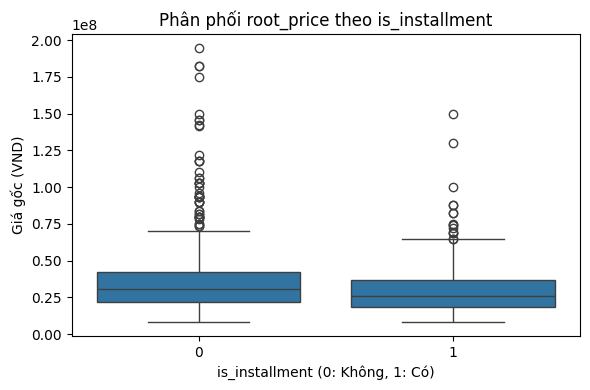

------------------------------

Phân tích biến: cam_ung
Số lượng giá trị unique: 2


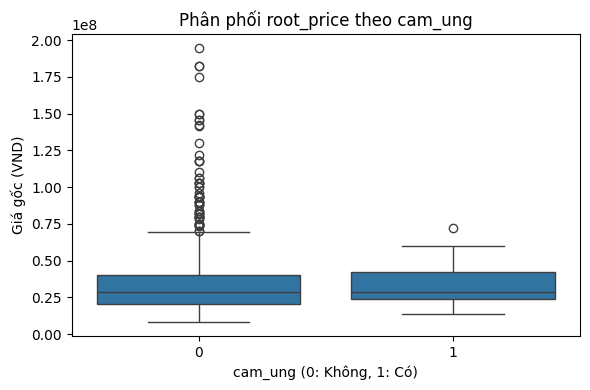

------------------------------

Phân tích biến: hoc_tap_van_phong
Số lượng giá trị unique: 2


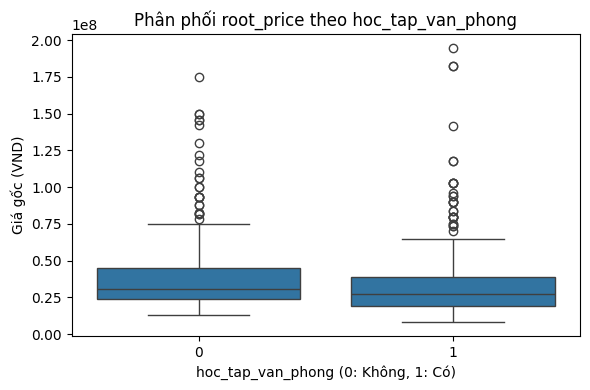

------------------------------

Phân tích biến: laptop_sang_tao_noi_dung
Số lượng giá trị unique: 2


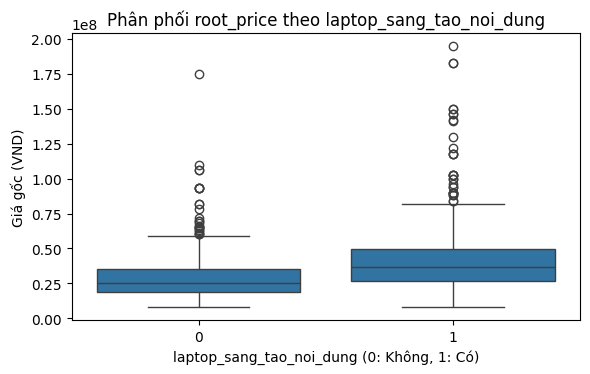

------------------------------

Phân tích biến: mong_nhe
Số lượng giá trị unique: 2


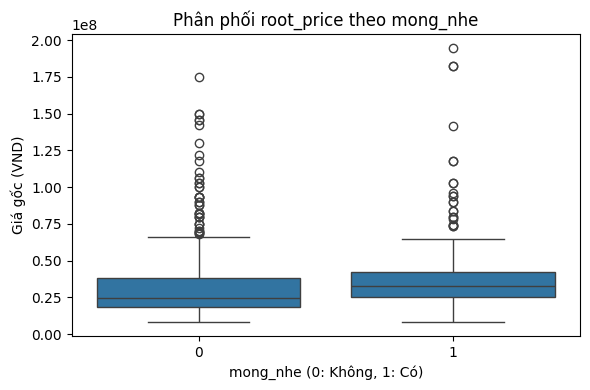

------------------------------

Phân tích biến: gaming
Số lượng giá trị unique: 2


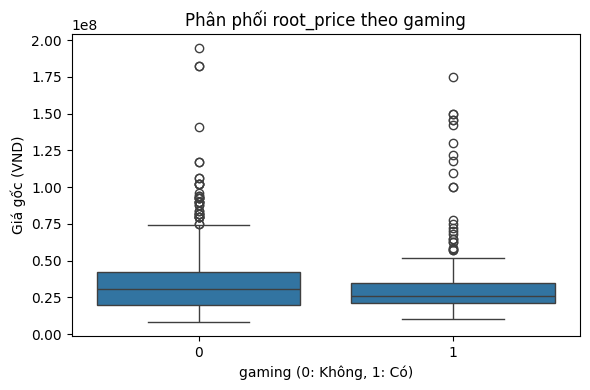

------------------------------

Phân tích biến: do_hoa_ky_thuat
Số lượng giá trị unique: 2


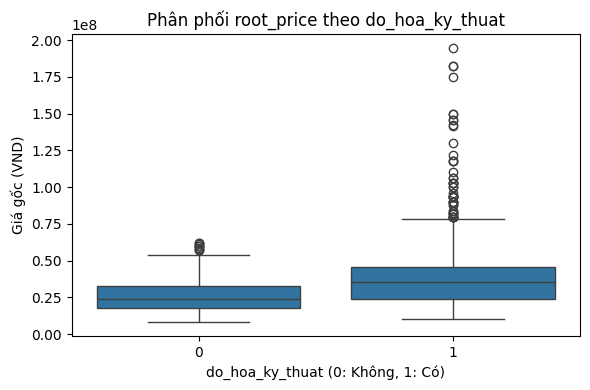

------------------------------

Phân tích biến: cao_cap_sang_trong
Số lượng giá trị unique: 2


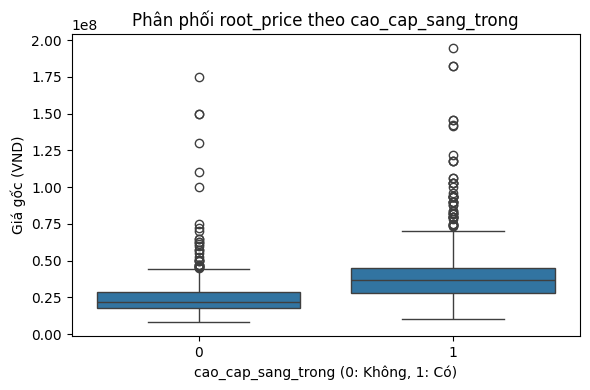

------------------------------


In [17]:
# Vòng lặp qua từng biến nhị phân
for var in binary:
    print(f"\nPhân tích biến: {var}")
    
    # Kiểm tra số lượng giá trị unique (nên là 2: 0 và 1)
    num_unique = df[var].nunique()
    print(f"Số lượng giá trị unique: {num_unique}")

    if num_unique < 2:
        print(f"Biến '{var}' chỉ có một giá trị duy nhất ({df[var].iloc[0]}). Không thể so sánh phân phối giá giữa hai nhóm.")
        print("-" * 30)
        continue
    elif num_unique > 2:
        print(f"Biến '{var}' có nhiều hơn hai giá trị unique ({num_unique}). Đây có thể không phải biến nhị phân.")
        print("-" * 30)
        continue

    # Vẽ Box Plot ngắn gọn
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[var], y=df['root_price'])
    plt.title(f'Phân phối root_price theo {var}')
    plt.xlabel(f'{var} (0: Không, 1: Có)')
    plt.ylabel('Giá gốc (VND)')
    plt.tight_layout()
    plt.show()

    print("-" * 30)

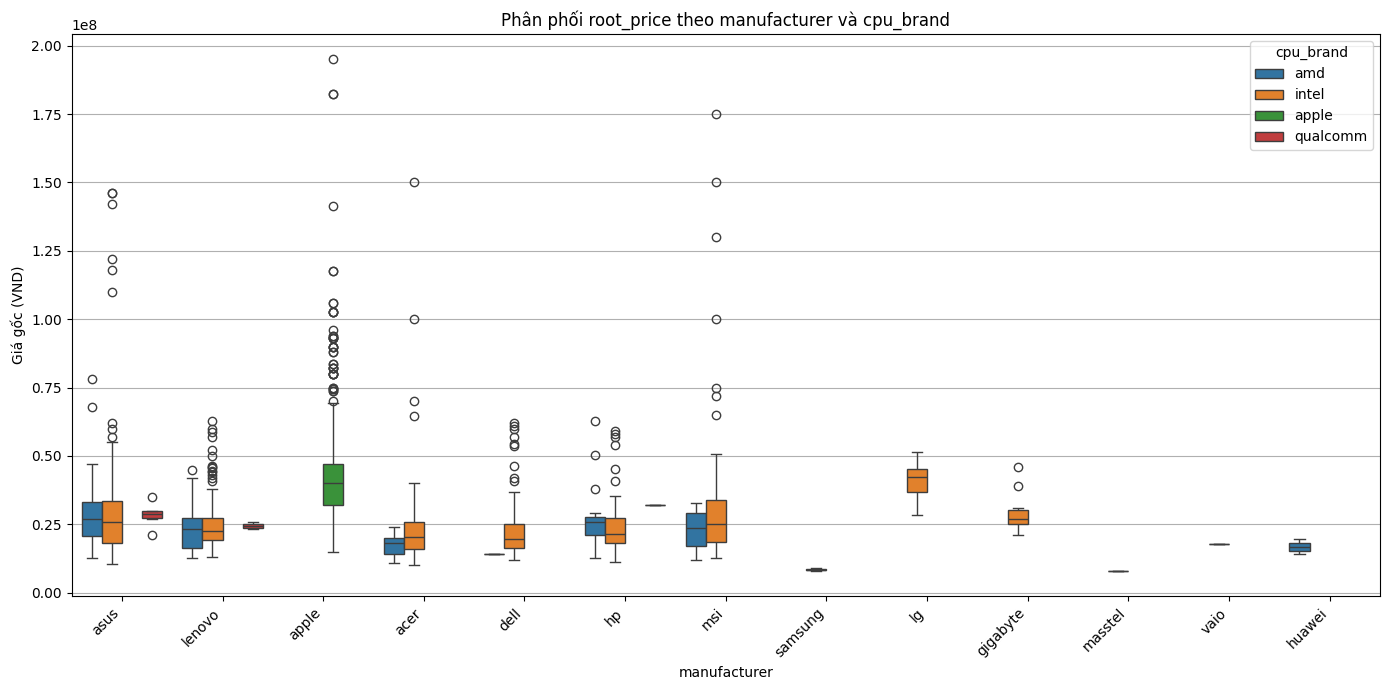

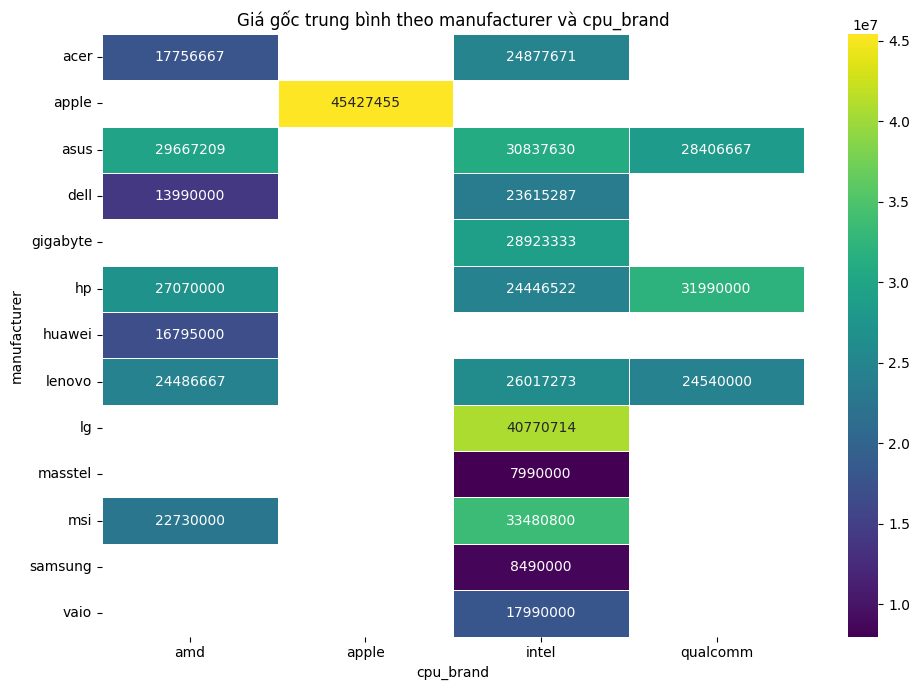

In [18]:
interaction_var1 = 'manufacturer'
interaction_var2 = 'cpu_brand'

# Kiểm tra xem có đủ sự kết hợp để vẽ không
if df.groupby([interaction_var1, interaction_var2]).ngroups > 1:
    plt.figure(figsize=(14, 7))
    sns.boxplot(x=df[interaction_var1], y=df['root_price'], hue=df[interaction_var2])
    plt.title(f'Phân phối root_price theo {interaction_var1} và {interaction_var2}')
    plt.xlabel(interaction_var1)
    plt.ylabel('Giá gốc (VND)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.legend(title=interaction_var2)
    plt.tight_layout()
    plt.show()

    # Hoặc sử dụng Heatmap của giá trung bình (phù hợp nếu số lượng nhóm không quá lớn)
    # Tính giá trung bình cho từng kết hợp
    avg_price_interaction = df.pivot_table(
        index=interaction_var1,
        columns=interaction_var2,
        values='root_price',
        aggfunc='mean'
    )

    plt.figure(figsize=(10, 7))
    sns.heatmap(avg_price_interaction, annot=True, fmt='.0f', cmap='viridis', linewidths=.5)
    plt.title(f'Giá gốc trung bình theo {interaction_var1} và {interaction_var2}')
    plt.xlabel(interaction_var2)
    plt.ylabel(interaction_var1)
    plt.tight_layout()
    plt.show()

else:
    print(f"Không đủ sự kết hợp giữa '{interaction_var1}' và '{interaction_var2}' để vẽ biểu đồ tương tác.")


- Biến root_price bị ảnh hưởng rõ rệt bởi hãng sản xuất và dòng CPU.
- CPU_brand là yếu tố quan trọng: Intel thường cao hơn AMD, Apple vượt trội nhất.
- Manufacturer là yếu tố quyết định vùng giá tổng thể, thể hiện phân khúc mà hãng nhắm tới (Apple/LG cao cấp, Asus/HP đa dạng, Masstel giá rẻ).

Chỉ vẽ tương tác cho Top 10 cpu_series phổ biến nhất.


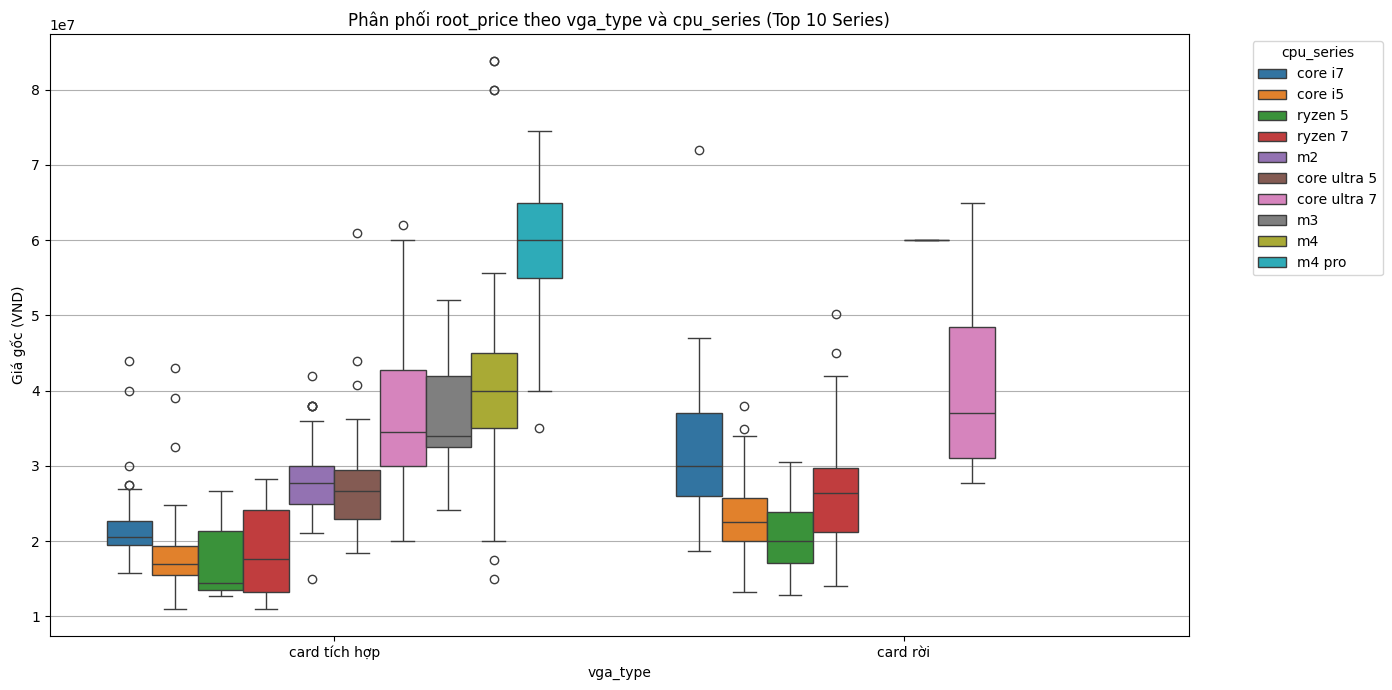

In [19]:
interaction_var1 = "vga_type"
interaction_var2 = "cpu_series"
target_col = "root_price"

# Kiểm tra số lượng CPU Series unique
cpu_series_counts = df[interaction_var2].value_counts()

# Giới hạn số lượng series để tránh quá tải biểu đồ
top_n_series = 10
if cpu_series_counts.size > top_n_series:
    top_series = cpu_series_counts.nlargest(top_n_series).index
    df_filtered = df[df[interaction_var2].isin(top_series)].copy()
    print(f"Chỉ vẽ tương tác cho Top {top_n_series} {interaction_var2} phổ biến nhất.")
else:
    df_filtered = df.copy()
    top_series = cpu_series_counts.index  # Dùng tất cả

# Vẽ Box Plot tương tác nếu có đủ nhóm
num_groups = df_filtered.groupby([interaction_var1, interaction_var2]).ngroups

if num_groups > 1 and not df_filtered.empty:
    plt.figure(figsize=(14, 7))
    sns.boxplot(
        x=df_filtered[interaction_var1],
        y=df_filtered[target_col],
        hue=df_filtered[interaction_var2],
    )

    plt.title(
        f"Phân phối {target_col} theo {interaction_var1} và {interaction_var2} "
        f"(Top {len(top_series)} Series)"
    )
    plt.xlabel(interaction_var1)
    plt.ylabel("Giá gốc (VND)")
    plt.grid(axis="y")
    plt.legend(
        title=interaction_var2,
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )
    plt.tight_layout()
    plt.show()
else:
    print(
        f"Không đủ sự kết hợp giữa '{interaction_var1}' và Top {len(top_series)} "
        f"'{interaction_var2}' để vẽ biểu đồ tương tác."
    )

- Dòng CPU và loại VGA đều ảnh hưởng mạnh đến giá gốc.
- Apple M-series dùng card tích hợp nhưng vẫn có giá cao nhất.
- Không thể mặc định “card rời = đắt hơn” — cần kết hợp dòng CPU để hiểu đúng.
- Dòng mới như Core Ultra 7, M4 Pro đang định hình lại phân khúc cao cấp.

In [20]:
# Gộp cột đặc trưng
features = binary + continuous + discrete + categorical
X = df[features]
y = df['root_price']

# ✅ Xử lý thiếu
categorical_features = categorical
numerical_features = binary + continuous + discrete

# ✅ Pipeline tiền xử lý
preprocessor = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='mean'), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# ✅ Pipeline hoàn chỉnh
pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# ✅ Train model
pipeline.fit(X, y)

# ✅ Lấy tên đặc trưng sau khi encode
ohe = pipeline.named_steps['preprocess'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(categorical_features)
all_features = numerical_features + list(ohe_features)

# ✅ Lấy importance
importances = pipeline.named_steps['model'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# ✅ Hiển thị top 20
print(importance_df.head(20))

                   Feature  Importance
19             ram_storage    0.544631
13           display_width    0.116766
12          display_height    0.054055
21     storage_max_support    0.045027
20              storage_gb    0.042426
22               cpu_cores    0.036955
10        battery_capacity    0.028198
15          product_weight    0.017607
23             cpu_threads    0.010350
16                width_mm    0.008532
17               height_mm    0.008476
14            display_size    0.007572
18                depth_mm    0.007508
8                cpu_speed    0.007431
11               ram_speed    0.007315
26                vga_vram    0.006294
9            cpu_max_speed    0.005294
64       cpu_series_m4 pro    0.003110
229  bluetooth_version_5.0    0.002732
24            refresh_rate    0.002178


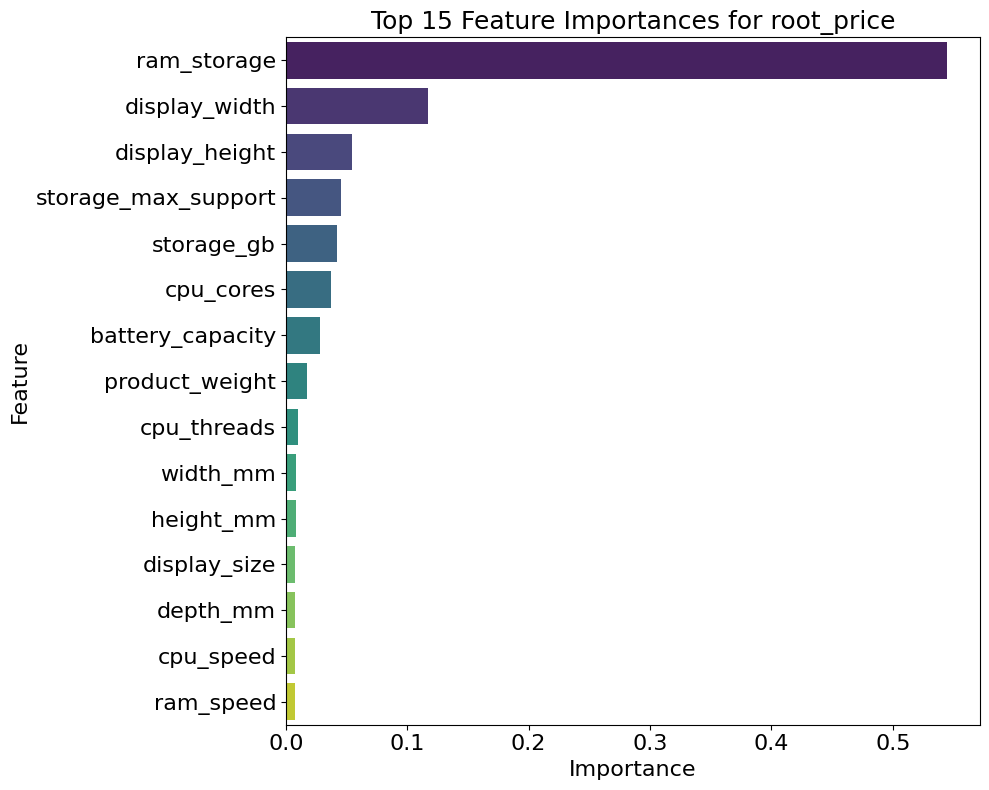

In [27]:
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')

# Tăng kích thước chữ
plt.title('Top 15 Feature Importances for root_price', fontsize=18)
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.tick_params(axis='both', labelsize=16)

plt.tight_layout()
plt.show()

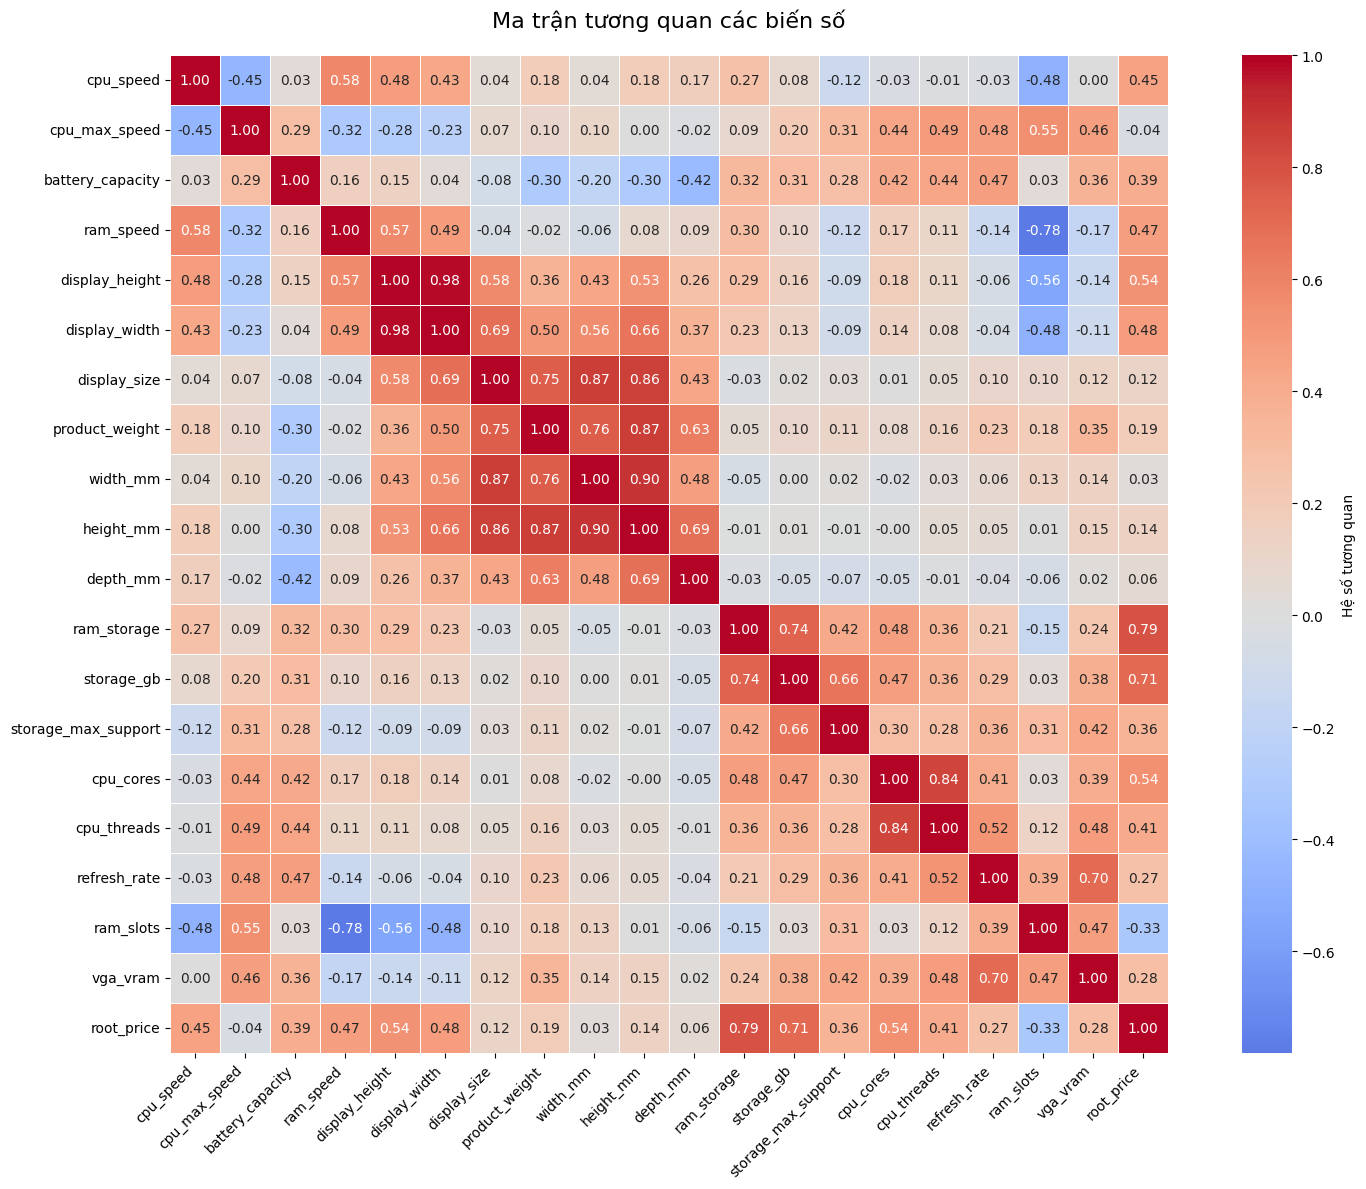

In [22]:
plt.figure(figsize=(16, 12))  
sns.heatmap(
    df[numeric + ['root_price']].corr(), 
    annot=True,                    
    fmt='.2f',                    
    cmap='coolwarm',              
    center=0,                     
    annot_kws={'size': 10},       
    square=True,                  
    linewidths=0.5,               
    cbar_kws={'label': 'Hệ số tương quan'}  
)
plt.title('Ma trận tương quan các biến số', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)  
plt.yticks(rotation=0, fontsize=10)             
plt.tight_layout()                               
plt.show()

**Tổng quan**

**Phạm vi và phân phối giá:**
- Giá laptop dao động từ 7.99 triệu VND (min) đến 194.99 triệu VND (max), với giá trung bình là 33.90 triệu VND và trung vị là 28.69 triệu VND.
- Giá phổ biến nhất nằm trong khoảng 20.49 triệu VND (Q1) đến 39.99 triệu VND (Q3), với IQR là 19.50 triệu VND, tập trung ở phân khúc trung bình.
- Giá bất thường (outliers) xuất hiện ở cả hai đầu, với các mẫu cao cấp (Apple, gần 200 triệu VND) và giá rẻ (Free DOS, Chrome OS, dưới 7.99 triệu VND).

**Yếu tố ảnh hưởng đến root_price:**

- Manufacturer: LG và Apple dẫn đầu với giá trung vị cao, Apple có phạm vi giá rộng và nhiều ngoại lai cao.
- CPU/GPU: Dòng CPU cao cấp (M4 Max, i9) và card đồ họa rời (NVIDIA, Apple) tăng giá đáng kể.
- RAM/Storage: RAM LPDDR5X/LPDDR5 và vỏ kim loại nâng cao giá trị.
- Các cờ tính năng: Webcam Full HD, và danh mục cao cấp/gaming là yếu tố quan trọng.

**Phân khúc giá theo đặc điểm:**

- Thương hiệu: LG, Apple ở phân khúc cao; Gigabyte, Intel, AMD ở phân khúc phổ thông/tầm trung.
- Card đồ họa rời: Tăng giá trung vị từ 0.25-0.5 triệu VND lên 0.5-1.0 triệu VND hoặc hơn.
- Dòng CPU: M4 Max (gần 1.0 triệu VND), M4 Pro (gần 5 triệu VND) cao nhất; Core i3, Ryzen thấp nhất (0.1-1 triệu VND).
- Danh mục sử dụng: Gaming, Đồ họa, Cao cấp vượt trội so với học tập/văn phòng, đặc biệt nhóm "Gaming: Yes, Premium: Yes".

- Tương quan dương mạnh với root_price: Các yếu tố như RAM (ram_storage, 0.79), lưu trữ (storage_gb, 0.71) và hiệu năng CPU (cpu_cores, cpu_threads, ~0.54) có ảnh hưởng lớn đến giá. Kích thước vật lý như display_height, display_width, depth_mm (0.50–0.54) cũng góp phần quan trọng.
- Tương quan âm: ram_slots có hệ số âm (-0.33), phản ánh việc nhiều laptop cao cấp sử dụng RAM hàn chết thay vì khe nâng cấp.
- Mối quan hệ giữa các đặc trưng: Nhiều cặp đặc trưng có tương quan cao (ví dụ cpu_cores–cpu_threads: 0.91), tiềm ẩn nguy cơ đa cộng tuyến cần xử lý trước khi xây mô hình.
- Tương quan yếu: Một số đặc trưng như battery_capacity, refresh_rate, ram_speed, vga_vram có ảnh hưởng không đáng kể đến giá, có thể do liên quan đến phân khúc chuyên biệt.

